## 데이터 전처리

### (1) 가격 + 수급안정화지수 + 재고량

In [1]:
import pandas as pd
from scipy import stats
import numpy as np

In [2]:
# 데이터 불러오기
price_data = pd.read_excel('니켈+가격_monthly.xls', skiprows=9)
stability_index_data = pd.read_excel('니켈+수급안정화지수2024-06-10.xls',skiprows=2)


# 필요 없는 데이터 삭제
price_data.drop(price_data.columns[[0,6,7,8,9]], axis=1, inplace=True)
stability_index_data.drop(stability_index_data.columns[0], axis=1, inplace=True)


# 기준일 컬럼 데이터 날짜로 변경
price_data['기준일'] = pd.to_datetime(price_data['기준일'])
stability_index_data['기준일'] = stability_index_data['기준일'].astype(str).apply(lambda x: f"{x[:4]}-{x[4:]}")
stability_index_data['기준일'] = pd.to_datetime(stability_index_data['기준일'])

# 기간 설정
price_data = price_data[(price_data['기준일']>='2017-01-01') & (price_data['기준일']<'2024-01-01')]


# # 데이터 병합
df_nickel = pd.merge(price_data, stability_index_data, on='기준일')



In [3]:
df_nickel

,기준일,기준가격,등락가,등락비율,재고량,수급안정화지수,전월대비 등락가,전월대비 등락율
0,2017-01-01,9984.29,-1028.96,-9.34,374047,NaN,0.00,0.00
1,2017-02-01,10619.50,635.21,6.36,381745,78.24,0.00,0.00
2,2017-03-01,10230.43,-389.07,-3.66,381883,74.56,-3.68,-4.70
3,2017-04-01,9668.61,-561.82,-5.49,375819,77.10,2.54,3.41
4,2017-05-01,9154.29,-514.32,-5.32,380589,80.06,2.96,3.84
...,...,...,...,...,...,...,...,...
79,2023-08-01,20497.73,-400.60,-1.92,37074,28.00,-1.55,-5.26
80,2023-09-01,19629.05,-868.68,-4.24,39516,30.97,2.97,10.62
81,2023-10-01,18255.23,-1373.82,-7.00,43572,31.98,1.01,3.26
82,2023-11-01,16979.77,-1275.46,-6.99,43515,41.74,9.76,30.53


In [4]:
df_nickel.drop(df_nickel.columns[[2,3,6,7]], axis=1, inplace=True)

In [5]:
df_nickel

,기준일,기준가격,재고량,수급안정화지수
0,2017-01-01,9984.29,374047,NaN
1,2017-02-01,10619.50,381745,78.24
2,2017-03-01,10230.43,381883,74.56
3,2017-04-01,9668.61,375819,77.10
4,2017-05-01,9154.29,380589,80.06
...,...,...,...,...
79,2023-08-01,20497.73,37074,28.00
80,2023-09-01,19629.05,39516,30.97
81,2023-10-01,18255.23,43572,31.98
82,2023-11-01,16979.77,43515,41.74


In [6]:
# 원/달러 환율 데이터
er_m = pd.read_csv('exchangerate_monthly.csv', encoding='euc-kr')
er_m = er_m[er_m.columns[[0,4]]]

er_m.rename(columns={'Date':'기준일', 'Close':'환율'},inplace=True)
er_m['기준일'] = pd.to_datetime(er_m['기준일'])

In [7]:
er_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준일     84 non-null     datetime64[ns]
 1   환율      84 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


In [8]:
er_m

,기준일,환율
0,2017-01-01,1169.209961
1,2017-02-01,1133.939941
2,2017-03-01,1117.020020
3,2017-04-01,1135.640015
4,2017-05-01,1123.900024
...,...,...
79,2023-08-01,1323.030029
80,2023-09-01,1351.930054
81,2023-10-01,1348.069946
82,2023-11-01,1288.359985


In [9]:
# 첫 번째 NaN => 2017년 1월 1일 기준가격과 유사한 3개월치(17년 2월-4월) 수급안정화지수의 평균값으로 대체
mean_value = df_nickel.loc[1:3, '수급안정화지수'].mean()
df_nickel.loc[0, '수급안정화지수'] = round(mean_value, 2)

In [10]:
df_nickel

,기준일,기준가격,재고량,수급안정화지수
0,2017-01-01,9984.29,374047,76.63
1,2017-02-01,10619.50,381745,78.24
2,2017-03-01,10230.43,381883,74.56
3,2017-04-01,9668.61,375819,77.10
4,2017-05-01,9154.29,380589,80.06
...,...,...,...,...
79,2023-08-01,20497.73,37074,28.00
80,2023-09-01,19629.05,39516,30.97
81,2023-10-01,18255.23,43572,31.98
82,2023-11-01,16979.77,43515,41.74


In [11]:
df_nickel = pd.merge(df_nickel, er_m, how='left', on='기준일')

In [12]:
df_nickel

,기준일,기준가격,재고량,수급안정화지수,환율
0,2017-01-01,9984.29,374047,76.63,1169.209961
1,2017-02-01,10619.50,381745,78.24,1133.939941
2,2017-03-01,10230.43,381883,74.56,1117.020020
3,2017-04-01,9668.61,375819,77.10,1135.640015
4,2017-05-01,9154.29,380589,80.06,1123.900024
...,...,...,...,...,...
79,2023-08-01,20497.73,37074,28.00,1323.030029
80,2023-09-01,19629.05,39516,30.97,1351.930054
81,2023-10-01,18255.23,43572,31.98,1348.069946
82,2023-11-01,16979.77,43515,41.74,1288.359985


### (2) 생산량 + 소비현황

In [13]:
# 데이터 불러오기
production_data = pd.read_csv('광종별국가별생산량.csv', encoding='euc-kr')
consumption_data = pd.read_csv('광종별 소비현황_20231231.csv', encoding='euc-kr')

# 필요없는 데이터 제거
production_data = production_data[(production_data['광종']=='니켈') & (production_data['품목']=='refined')]
# 소비현황 데이터에 refined만 있으므로 생산량 데이터에서 nickel refined만 가져오기
consumption_data = consumption_data[consumption_data['광종']=='니켈']


In [14]:
# 필요없는 컬럼 제거
production_data.drop(production_data.columns[[0,1,2,3,4]], axis=1, inplace=True)

# 행열전환
production_data = production_data.T

# 연도별 합계 계산해서 데이터프레임 생성
production_data= production_data.sum(axis=1).to_frame(name='생산량')

# 인덱스 이름 연도(숫자)만 나오게 변경
production_data.index = production_data.index.str.replace(' 생산량', '')

In [15]:
# 인덱스 컬럼으로 변경, '연도'로 이름 변경
production_data.reset_index(inplace=True)
production_data.columns = ['연도', '생산량']

In [16]:
# 필요없는 컬럼 제거
consumption_data.drop(consumption_data.columns[[0,1,2,3,4]], axis=1, inplace=True)

# 행열전환
consumption_data = consumption_data.T

# 연도별 합계 계산해서 데이터프레임 생성
consumption_data= consumption_data.sum(axis=1).to_frame(name='소비량')

# 인덱스 이름 연도(숫자)만 나오게 변경
consumption_data.index = consumption_data.index.str.replace(' 소비량', '')

In [17]:
# 인덱스 컬럼으로 변경, '연도'로 이름 변경
consumption_data.reset_index(inplace=True)
consumption_data.columns = ['연도', '소비량']

In [18]:
consumption_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연도      13 non-null     object 
 1   소비량     13 non-null     float64
dtypes: float64(1), object(1)
memory usage: 336.0+ bytes


In [19]:
production_consumption = pd.merge(production_data, consumption_data, on='연도')

In [20]:
production_consumption['연도'] = production_consumption['연도'].astype('int')

In [21]:
# 2017년부터 2023년 데이터만 필요
production_consumption = production_consumption[production_consumption['연도']>=2017]
production_consumption.reset_index(drop=True, inplace=True)

In [22]:
production_consumption

,연도,생산량,소비량
0,2017,2065.960,2090.518
1,2018,2251.992,2339.103
2,2019,2430.243,2430.139
3,2020,2528.167,2442.837
4,2021,2784.683,2962.181
5,2022,3089.143,3003.505
6,2023,3429.284,3171.547


## 데이터 합치기 : (1) + (2)

In [23]:
import numpy as np

df_nickel['생산량'] = np.nan
df_nickel['소비량'] = np.nan

In [24]:
df_nickel

,기준일,기준가격,재고량,수급안정화지수,환율,생산량,소비량
0,2017-01-01,9984.29,374047,76.63,1169.209961,NaN,NaN
1,2017-02-01,10619.50,381745,78.24,1133.939941,NaN,NaN
2,2017-03-01,10230.43,381883,74.56,1117.020020,NaN,NaN
3,2017-04-01,9668.61,375819,77.10,1135.640015,NaN,NaN
4,2017-05-01,9154.29,380589,80.06,1123.900024,NaN,NaN
...,...,...,...,...,...,...,...
79,2023-08-01,20497.73,37074,28.00,1323.030029,NaN,NaN
80,2023-09-01,19629.05,39516,30.97,1351.930054,NaN,NaN
81,2023-10-01,18255.23,43572,31.98,1348.069946,NaN,NaN
82,2023-11-01,16979.77,43515,41.74,1288.359985,NaN,NaN


In [25]:
# 생산량과 소비량을 연도별로 월 단위로 나누어서 할당

for i, r in df_nickel.iterrows():
    year = r['기준일'].year
    
    for idx, row in production_consumption.iterrows():
        if row['연도']==year:
            df_nickel.iloc[i, 5] = round(row['생산량']/12, 2)
            df_nickel.iloc[i, 6] = round(row['소비량']/12, 2)

In [26]:
df_nickel

,기준일,기준가격,재고량,수급안정화지수,환율,생산량,소비량
0,2017-01-01,9984.29,374047,76.63,1169.209961,172.16,174.21
1,2017-02-01,10619.50,381745,78.24,1133.939941,172.16,174.21
2,2017-03-01,10230.43,381883,74.56,1117.020020,172.16,174.21
3,2017-04-01,9668.61,375819,77.10,1135.640015,172.16,174.21
4,2017-05-01,9154.29,380589,80.06,1123.900024,172.16,174.21
...,...,...,...,...,...,...,...
79,2023-08-01,20497.73,37074,28.00,1323.030029,285.77,264.30
80,2023-09-01,19629.05,39516,30.97,1351.930054,285.77,264.30
81,2023-10-01,18255.23,43572,31.98,1348.069946,285.77,264.30
82,2023-11-01,16979.77,43515,41.74,1288.359985,285.77,264.30


In [27]:
df_nickel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   기준일      84 non-null     datetime64[ns]
 1   기준가격     84 non-null     float64       
 2   재고량      84 non-null     int64         
 3   수급안정화지수  84 non-null     float64       
 4   환율       84 non-null     float64       
 5   생산량      84 non-null     float64       
 6   소비량      84 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 4.7 KB


In [28]:
df_nickel.describe()

,기준일,기준가격,재고량,수급안정화지수,환율,생산량,소비량
count,84,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,2020-06-16 01:08:34.285714176,16689.513571,193718.738095,39.705476,1173.638280,221.184286,219.522857
min,2017-01-01 00:00:00,8930.680000,37074.000000,6.240000,0.115380,172.160000,174.210000
25%,2018-09-23 12:00:00,12477.230000,72929.250000,16.585000,1119.762543,187.670000,194.930000
50%,2020-06-16 00:00:00,15209.440000,206399.000000,38.860000,1168.534973,210.680000,203.570000
75%,2022-03-08 18:00:00,19990.800000,255798.500000,60.375000,1230.577515,257.430000,250.290000
max,2023-12-01 00:00:00,33298.420000,385273.000000,82.860000,1430.170044,285.770000,264.300000
std,NaN,5534.406269,114615.840014,24.056437,155.689197,37.233159,31.585517


In [29]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.dates as mdates

plt.rc('font', family='Malgun Gothic')
%matplotlib inline

matplotlib.rcParams['axes.unicode_minus']=False

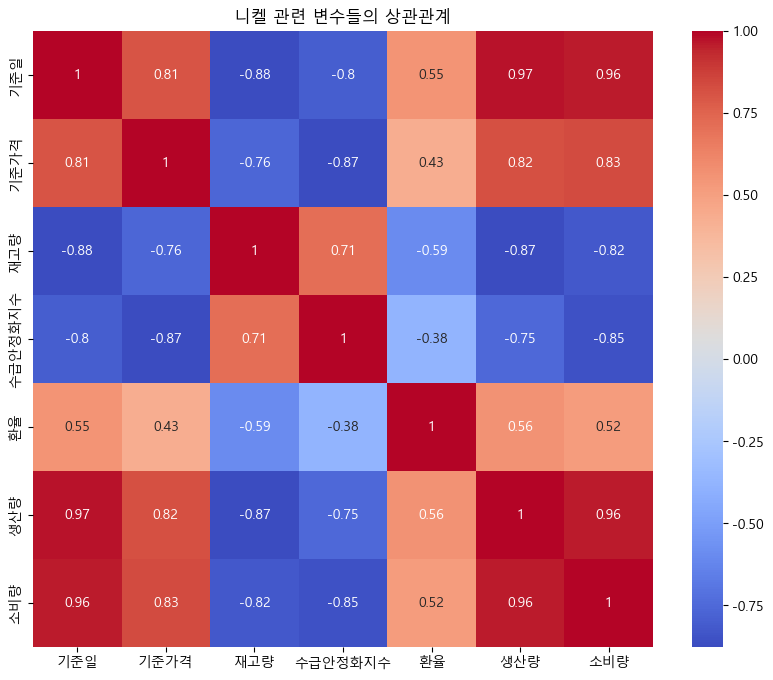

In [30]:

plt.figure(figsize=(10, 8))
sns.heatmap(df_nickel.corr(), annot=True, cmap='coolwarm')
plt.title('니켈 관련 변수들의 상관관계')
plt.show()

소비량과 생산량이 클수록, 수급안정화지수와 LME(London Metal Exchange) 재고량이 낮을수록 가격이 높아짐

Text(0, 0.5, 'price')

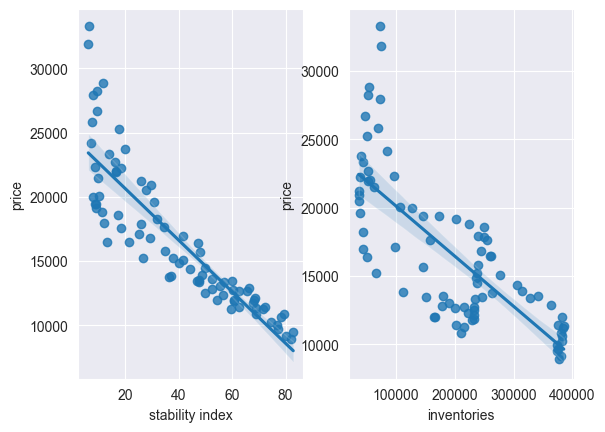

In [31]:
# 수급안정화지수과 재고량과 가격의 관계 관찰

sns.set_style('darkgrid')
sns.set_style(rc={'figure.figsize':(12,6)})

fig, ax = plt.subplots(ncols=2)
sns.regplot(x='수급안정화지수', y='기준가격', data=df_nickel, ax=ax[0])
ax[0].set_xlabel('stability index')
ax[0].set_ylabel('price')

sns.regplot(x='재고량', y='기준가격', data=df_nickel, ax=ax[1])
ax[1].set_xlabel('inventories')
ax[1].set_ylabel('price')

---

## 데이터 전처리

앞에서는 월별 데이터 사용했으나 prophet, arima 예측에는 일별데이터 사용

In [32]:
# 가격과 재고량 일별 데이터
price_d = pd.read_excel('니켈+가격_daily.xls', skiprows=9)
price_d.drop(price_d.columns[[0,6,7,8,9]], axis=1, inplace=True)
price_d['기준일'] = pd.to_datetime(price_d['기준일'])
price_d = price_d[(price_d['기준일']>='2017-01-01') & (price_d['기준일']<='2023-12-31')]
price_d = price_d[price_d.columns[[0,1,4]]]

In [33]:
price_d 

,기준일,기준가격,재고량
650,2017-01-03,10205,372066
651,2017-01-04,9975,371724
652,2017-01-05,10230,370920
653,2017-01-06,10185,370920
654,2017-01-09,10245,372012
...,...,...,...
2412,2023-12-21,16670,53676
2413,2023-12-22,16360,56058
2414,2023-12-27,16355,57804
2415,2023-12-28,16405,62022


In [34]:
# 원/달러 환율 데이터
er = pd.read_csv('exchangerate.csv', encoding='euc-kr')
er = er[er.columns[[0,4]]]

er.rename(columns={'Date':'기준일', 'Close':'환율'},inplace=True)
er['기준일'] = pd.to_datetime(er['기준일'])
er.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준일     1825 non-null   datetime64[ns]
 1   환율      1822 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.6 KB


In [35]:
# 데이터 합치기
merged_df = pd.merge(price_d, er, how='left', on='기준일')

In [36]:
# interpolate으로 nan값 채우기
merged_df['환율'] = merged_df['환율'].interpolate(method='linear')

In [37]:
merged_df

,기준일,기준가격,재고량,환율
0,2017-01-03,10205,372066,1202.930054
1,2017-01-04,9975,371724,1206.010010
2,2017-01-05,10230,370920,1194.479980
3,2017-01-06,10185,370920,1180.630005
4,2017-01-09,10245,372012,1201.099976
...,...,...,...,...
1762,2023-12-21,16670,53676,1296.979980
1763,2023-12-22,16360,56058,1291.709961
1764,2023-12-27,16355,57804,1293.920044
1765,2023-12-28,16405,62022,1294.760010


In [38]:
# 생산량 소비량 데이터 
# 연도를 날짜 형식으로 변환 (각 연도의 12월 31일로 설정)
production_consumption['연도'] = pd.to_datetime(production_consumption['연도'], format='%Y') + pd.offsets.DateOffset(months=11, days=30)


In [39]:
production_consumption.rename(columns={'연도':'기준일'}, inplace=True)

In [40]:
production_consumption

,기준일,생산량,소비량
0,2017-12-31,2065.960,2090.518
1,2018-12-31,2251.992,2339.103
2,2019-12-31,2430.243,2430.139
3,2020-12-31,2528.167,2442.837
4,2021-12-31,2784.683,2962.181
5,2022-12-31,3089.143,3003.505
6,2023-12-31,3429.284,3171.547


In [41]:
df_tmp = merged_df.copy()

In [42]:
import numpy as np
from scipy import stats
# 이상치 제거
# Z-score를 사용한 이상치 탐지
z_scores = np.abs(stats.zscore(df_tmp['기준가격']))
threshold = 3 # 임계값
z_outliers = (z_scores > threshold)

# 이상치 날짜 리스트 만들기
date_list = []
for i, r in df_tmp[z_outliers].iterrows():
    d = r[0]
    date_list.append(d)

# 해당 날짜 가격 nan으로 대체
for i, r in df_tmp.iterrows():
    if r['기준일'] in date_list:
        df_tmp.at[i, '기준가격'] = np.nan

# 결측치 보간
df_tmp['기준가격'] = df_tmp['기준가격'].interpolate(method='linear').round(2)

In [43]:
date_list

[Timestamp('2022-03-07 00:00:00'),
 Timestamp('2022-03-23 00:00:00'),
 Timestamp('2022-03-24 00:00:00'),
 Timestamp('2022-03-25 00:00:00'),
 Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-04 00:00:00'),
 Timestamp('2022-04-05 00:00:00'),
 Timestamp('2022-04-06 00:00:00'),
 Timestamp('2022-04-07 00:00:00'),
 Timestamp('2022-04-08 00:00:00'),
 Timestamp('2022-04-19 00:00:00'),
 Timestamp('2022-04-20 00:00:00'),
 Timestamp('2022-04-21 00:00:00'),
 Timestamp('2022-04-22 00:00:00'),
 Timestamp('2022-04-27 00:00:00'),
 Timestamp('2022-04-28 00:00:00')]

In [44]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1767 entries, 0 to 1766
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준일     1767 non-null   datetime64[ns]
 1   기준가격    1767 non-null   float64       
 2   재고량     1767 non-null   int64         
 3   환율      1767 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 55.3 KB


In [45]:
df_tmp[df_tmp['기준일'].isin(date_list)]

,기준일,기준가격,재고량,환율
1309,2022-03-07,30300.00,76830,1216.709961
1321,2022-03-23,31260.00,73242,1214.949951
1322,2022-03-24,31720.00,73074,1218.010010
1323,2022-03-25,32180.00,72924,1217.550049
1324,2022-03-28,32640.00,72816,1224.380005
1327,2022-03-31,32775.00,72570,1210.439941
1329,2022-04-04,32820.83,73362,1218.780029
1330,2022-04-05,32841.67,72924,1213.900024
1331,2022-04-06,32862.50,73902,1218.750000
1332,2022-04-07,32883.33,74190,1217.599976


## PROPHET

In [226]:
# prophet 예측 모델 함수

from prophet import Prophet

def forecast_with_prophet(data, column, periods, freq):
    df = data[['기준일', column]].rename(columns={'기준일': 'ds', column: 'y'})
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)
            
    # 예측 결과 시각화
    fig1 = model.plot(forecast)
    plt.show()

    # 구성 요소 시각화
    fig2 = model.plot_components(forecast)
    plt.show()
    return forecast[['ds', 'yhat']].tail(periods)



17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing


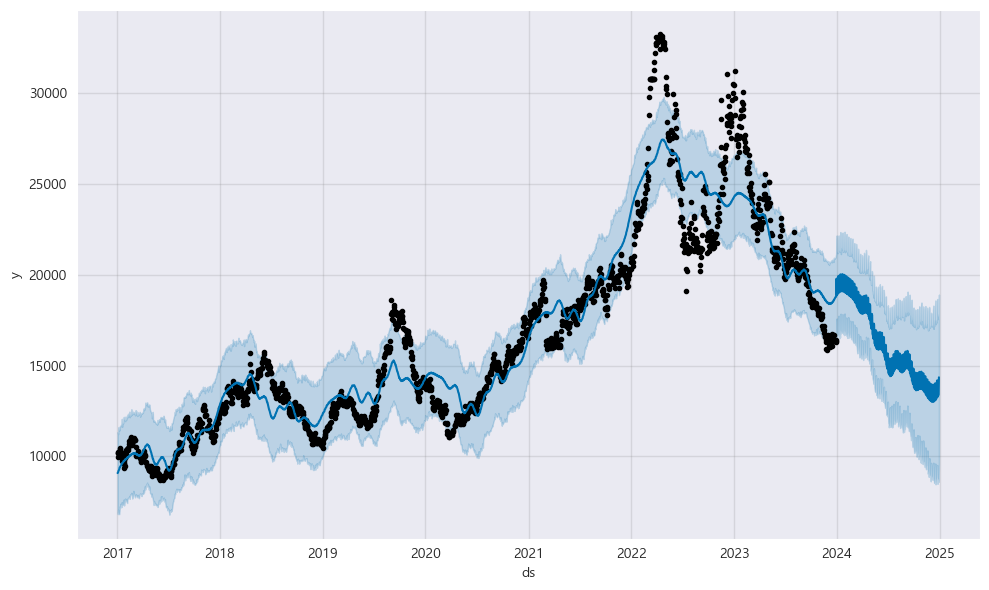

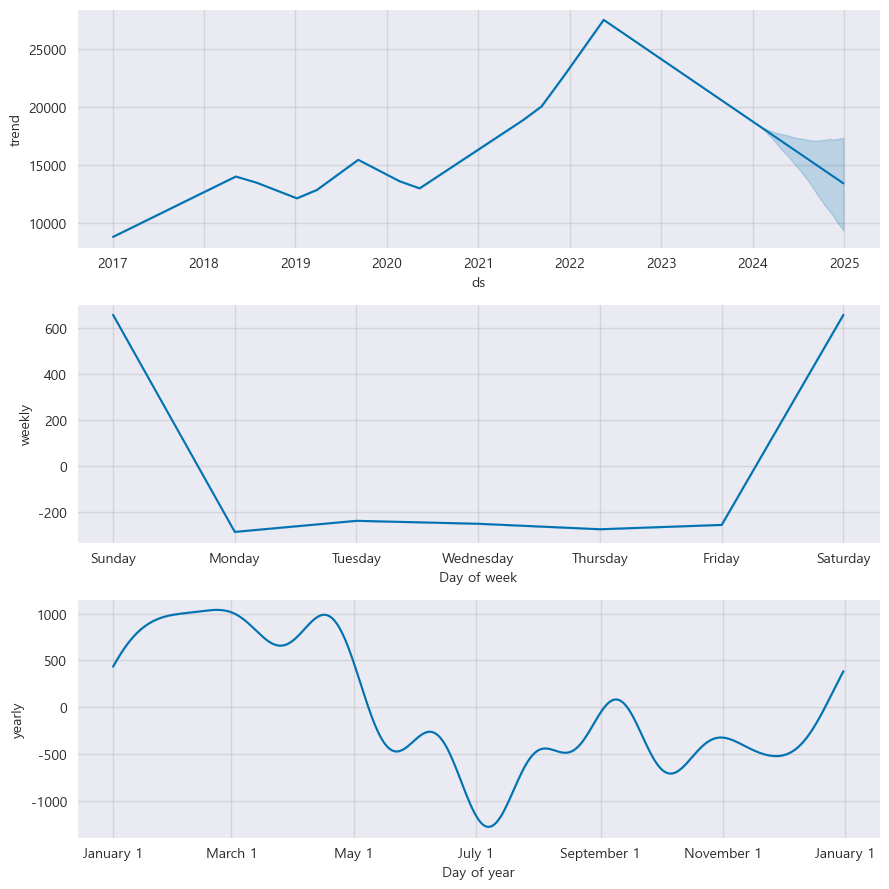

17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing


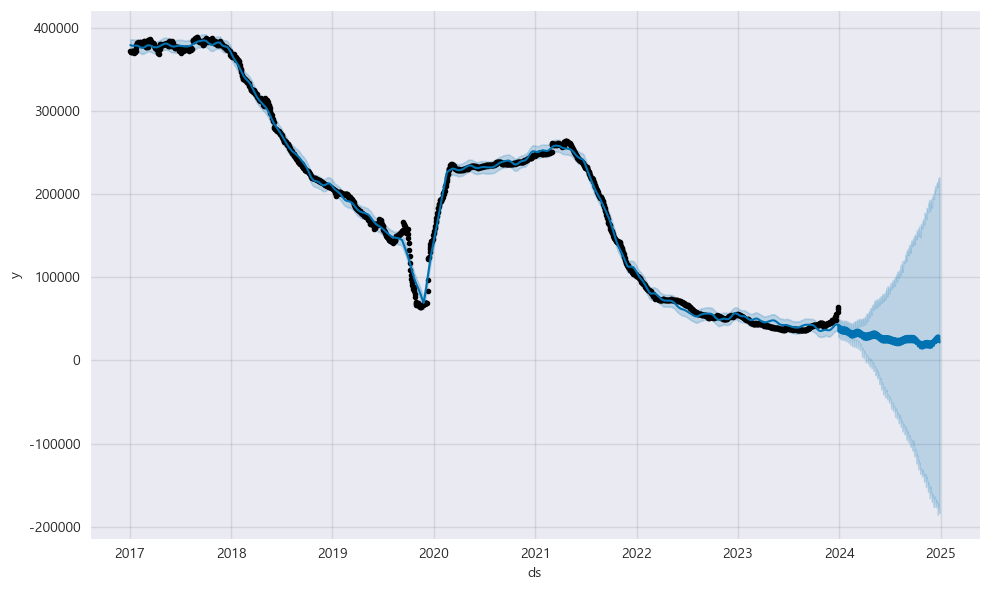

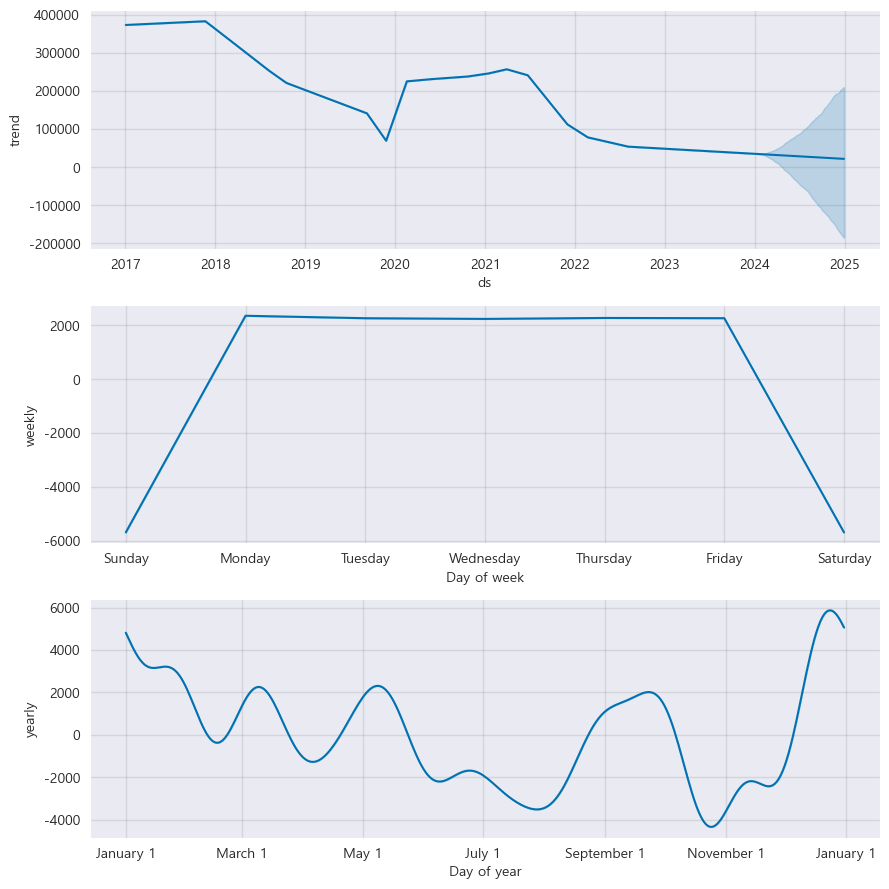

17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1] done processing


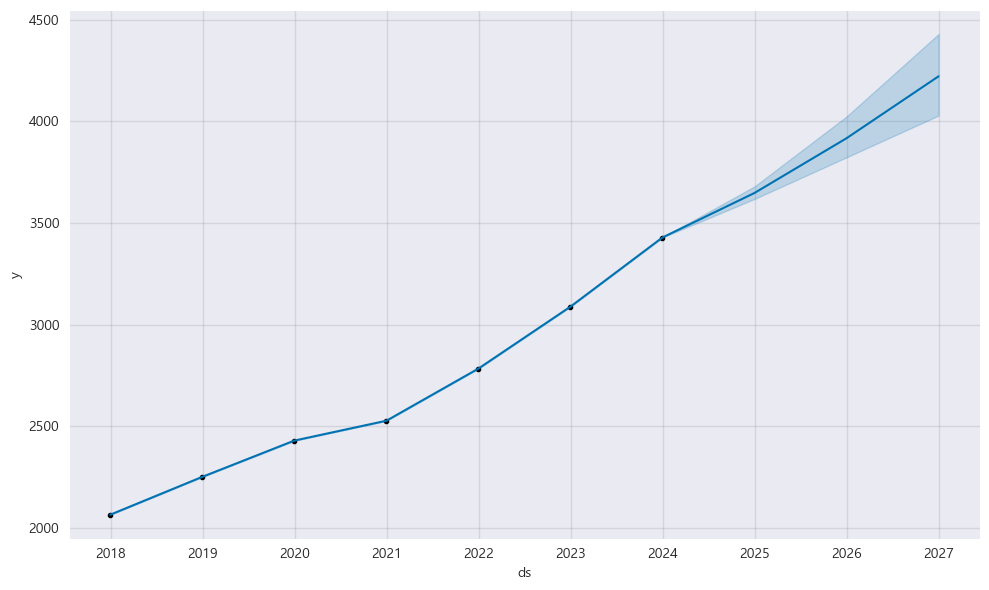

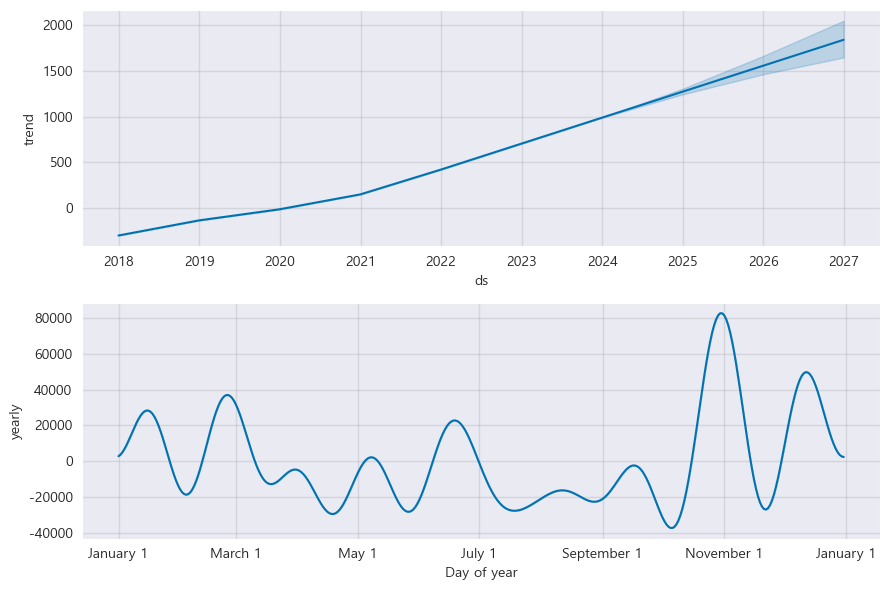

17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing


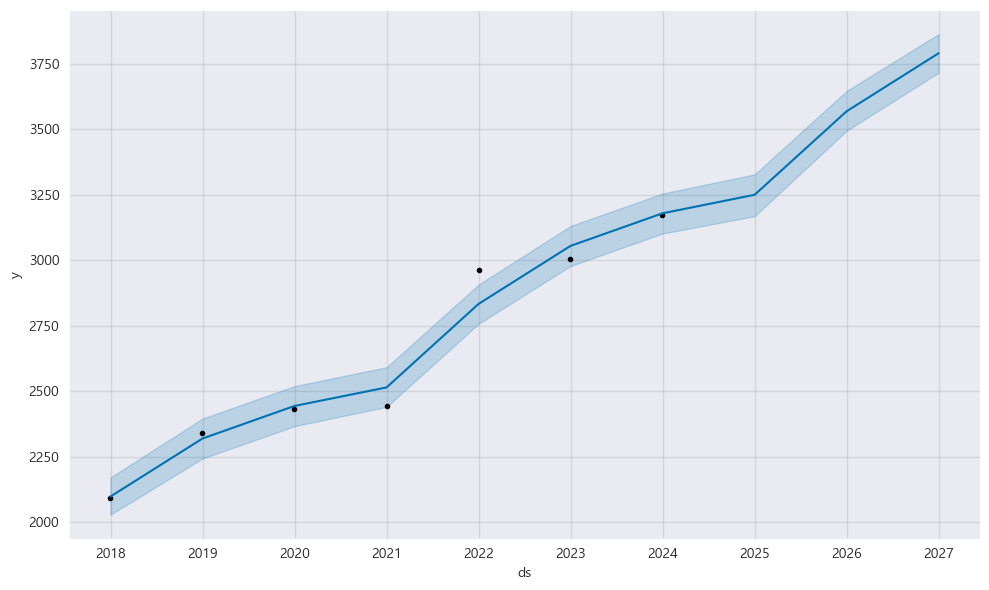

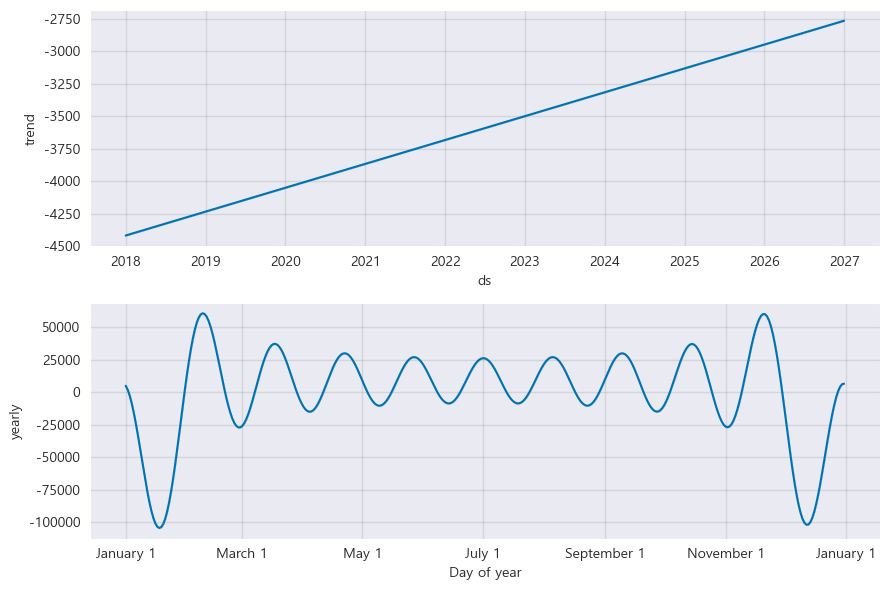

17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1] done processing


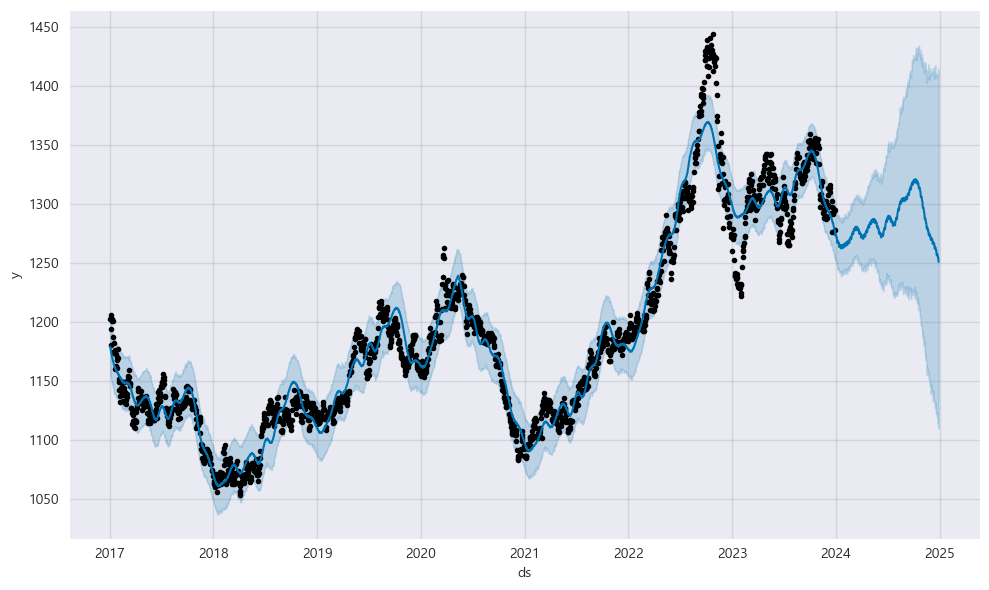

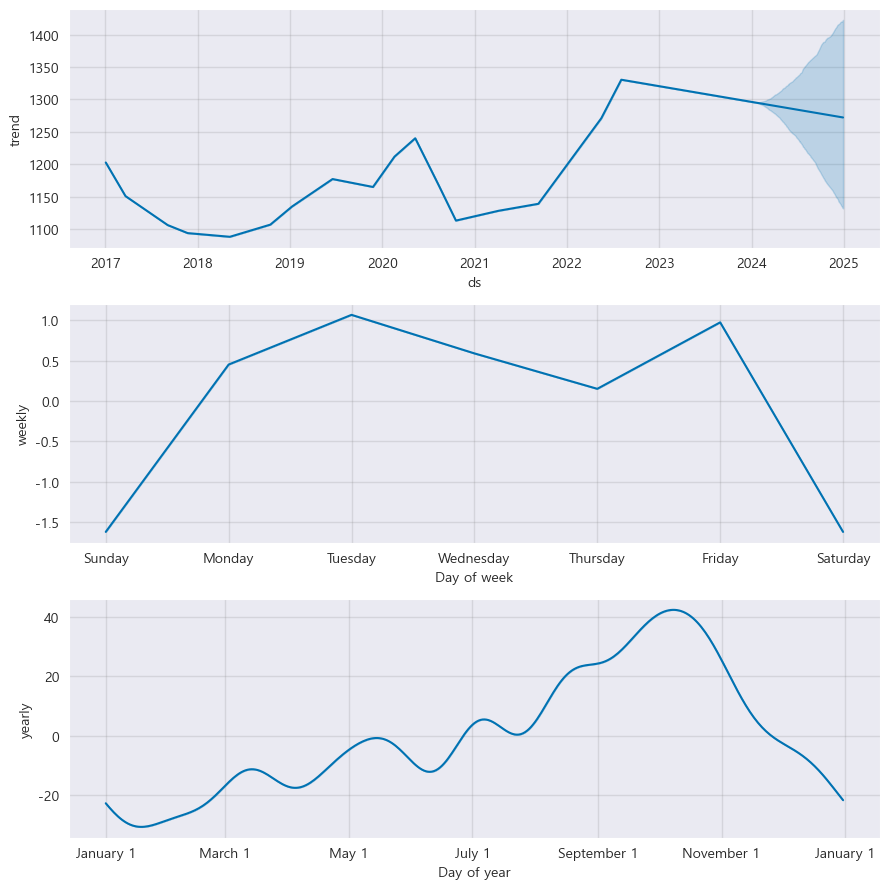

In [227]:
# 일별 예측, 연도별 예측으로 나눠서 예측
prophet_forecasts_d = pd.DataFrame()
prophet_forecasts_y = pd.DataFrame()
for column in ['기준가격', '재고량', '생산량', '소비량', '환율']:
    if column in ['기준가격', '재고량', '환율']: # 3년치 예측
        forecast_d = forecast_with_prophet(df_tmp, column, 365, 'D')
        prophet_forecasts_d['ds'] = forecast_d[['ds']]
        prophet_forecasts_d[column] = forecast_d[['yhat']]
        

    if column in ['생산량', '소비량']: # 3년치 예측
        forecast_y = forecast_with_prophet(production_consumption, column, 3, 'Y')
        prophet_forecasts_y['ds'] = forecast_y[['ds']]
        prophet_forecasts_y[column] = forecast_y[['yhat']]


In [48]:
prophet_forecasts_d

,ds,기준가격,재고량,환율
1767,2023-12-30,19766.710989,34760.689296,1274.062553
1768,2023-12-31,19792.730179,34545.462898,1273.128813
1769,2024-01-01,18873.581438,42352.271907,1274.280779
1770,2024-01-02,18945.868807,42025.964637,1273.993306
1771,2024-01-03,18955.992419,41762.828598,1272.635558
...,...,...,...,...
2127,2024-12-24,13348.878120,30066.117189,1257.434703
2128,2024-12-25,13363.867843,29970.838824,1256.032993
2129,2024-12-26,13367.936857,29899.533876,1254.658793
2130,2024-12-27,13414.516547,29751.064269,1254.539940


In [49]:
prophet_forecasts_y

,ds,생산량,소비량
7,2024-12-31,3648.794281,3249.542706
8,2025-12-31,3917.901521,3568.176923
9,2026-12-31,4222.362699,3789.673982


In [50]:
prophet_forecasts_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 1767 to 2131
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      365 non-null    datetime64[ns]
 1   기준가격    365 non-null    float64       
 2   재고량     365 non-null    float64       
 3   환율      365 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.5 KB


In [ ]:
    
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.show()

# 구성 요소 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [51]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.dates as mdates

plt.rc('font', family='Malgun Gothic')
%matplotlib inline

matplotlib.rcParams['axes.unicode_minus']=False

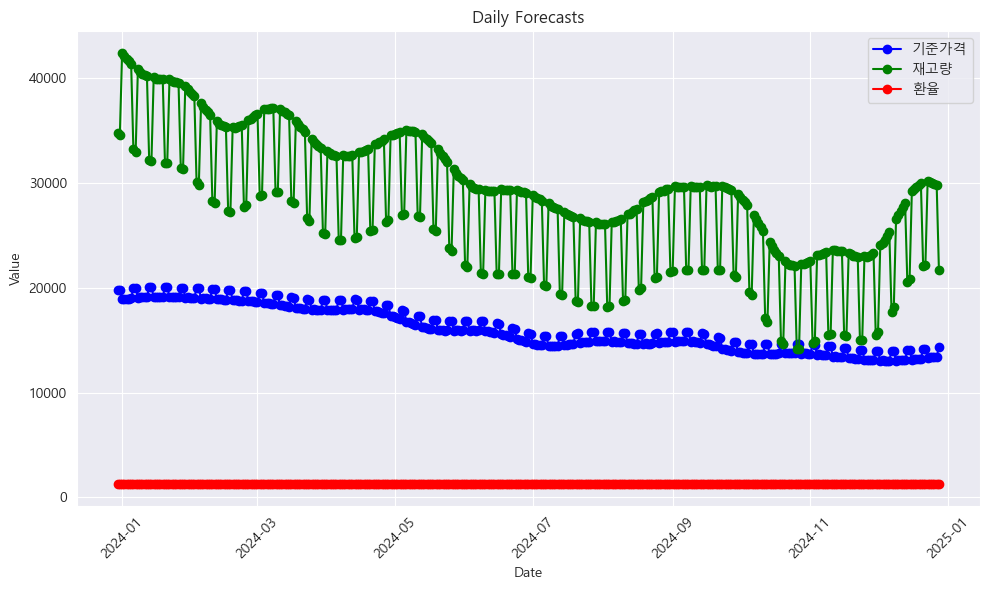

In [225]:
# 그래프 그리기
plt.figure(figsize=(10, 6))

# 기준가격 예측 그래프
plt.plot(prophet_forecasts_d['ds'], prophet_forecasts_d['기준가격'], marker='o', linestyle='-', color='b', label='기준가격')

# 재고량 예측 그래프
plt.plot(prophet_forecasts_d['ds'], prophet_forecasts_d['재고량'], marker='o', linestyle='-', color='g', label='재고량')


# 환율 예측 그래프
plt.plot(prophet_forecasts_d['ds'], prophet_forecasts_d['환율'], marker='o', linestyle='-', color='r', label='환율')

# 그래프 제목과 축 레이블 설정
plt.title('Daily Forecasts')
plt.xlabel('Date')
plt.ylabel('Value')

# 범례 추가
plt.legend()

# x축 라벨 회전
plt.xticks(rotation=45)

# 그래프 출력
plt.tight_layout()
plt.show()

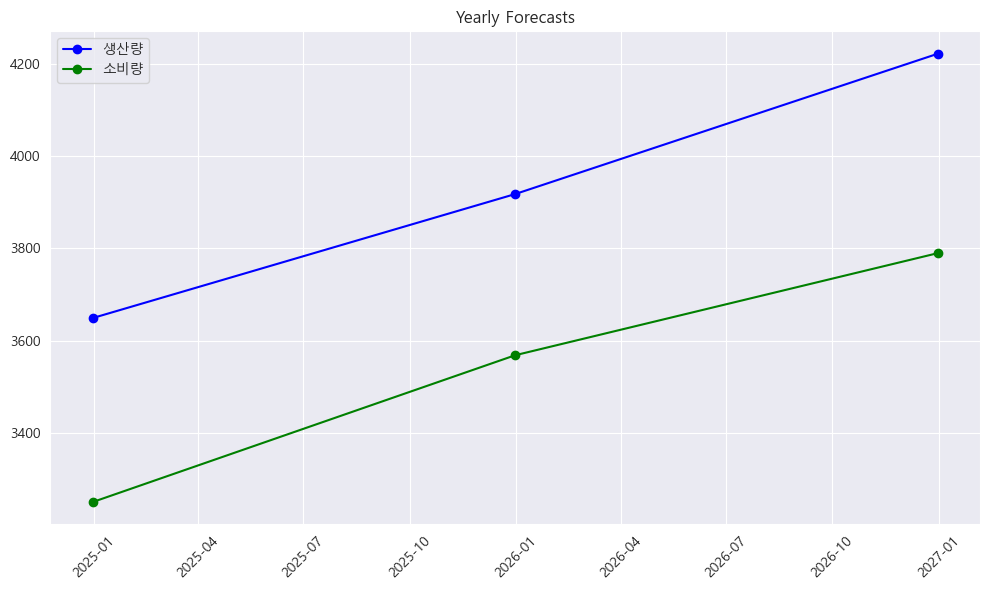

In [220]:
# 그래프 그리기
plt.figure(figsize=(10, 6))

# 기준가격 예측 그래프
plt.plot(prophet_forecasts_y['ds'], prophet_forecasts_y['생산량'], marker='o', linestyle='-', color='b', label='생산량')

# 재고량 예측 그래프
plt.plot(prophet_forecasts_y['ds'], prophet_forecasts_y['소비량'], marker='o', linestyle='-', color='g', label='소비량')



# 그래프 제목과 축 레이블 설정
plt.title('Yearly Forecasts')
plt.xlabel('')
plt.ylabel('')

# 범례 추가
plt.legend()

# x축 라벨 회전
plt.xticks(rotation=45)

# 그래프 출력
plt.tight_layout()
plt.show()

### ARIMA

In [54]:

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [55]:

# 정상성 검정 함수
def check_stationarity(timeseries):
    # 원본 데이터의 rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # rolling statistics plot
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Dickey-Fuller Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

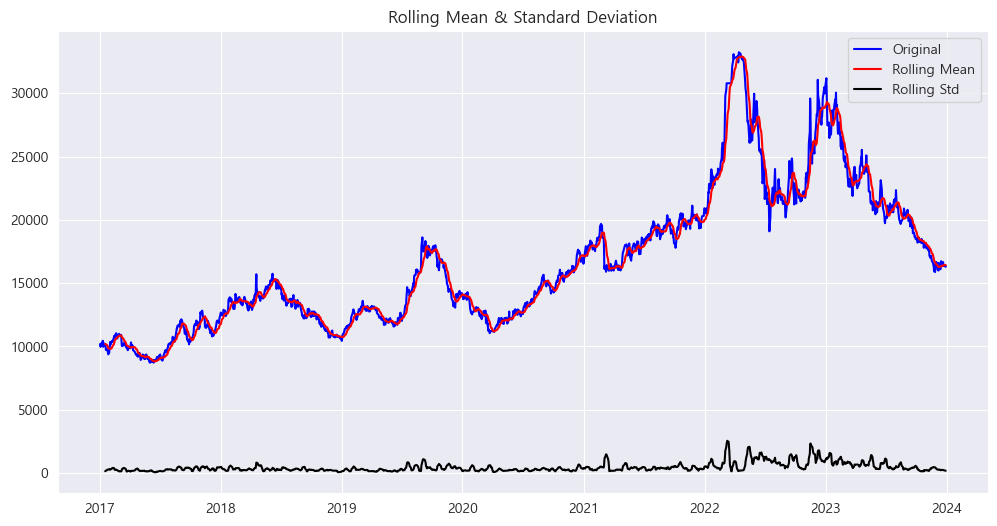

Results of Dickey-Fuller Test:
Test Statistic                   -1.732377
p-value                           0.414513
#Lags Used                        5.000000
Number of Observations Used    1761.000000
Critical Value (1%)              -3.434069
Critical Value (5%)              -2.863183
Critical Value (10%)             -2.567645
dtype: float64


In [56]:
# 정상성 검정 수행
price_adf =  df_tmp.set_index('기준일')['기준가격']
check_stationarity(price_adf)

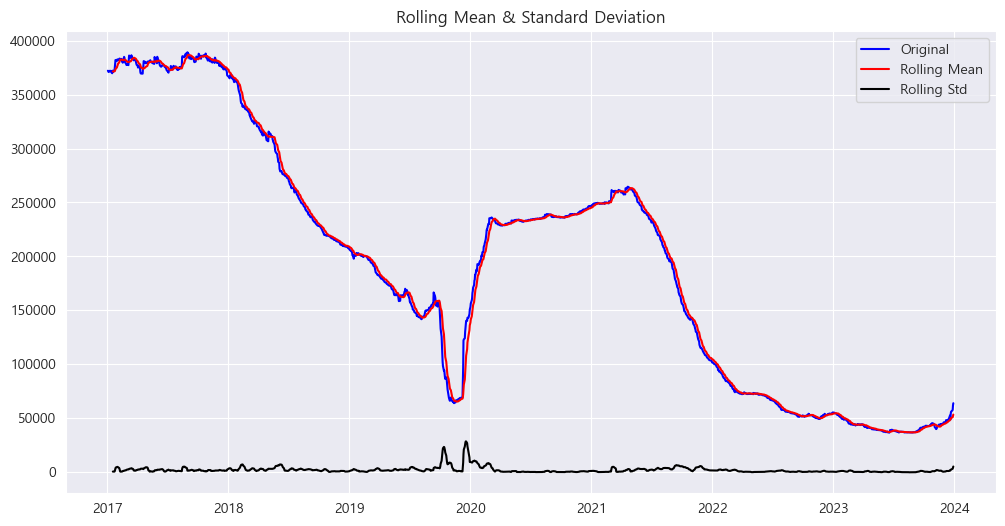

Results of Dickey-Fuller Test:
Test Statistic                   -1.636374
p-value                           0.464156
#Lags Used                       24.000000
Number of Observations Used    1742.000000
Critical Value (1%)              -3.434109
Critical Value (5%)              -2.863201
Critical Value (10%)             -2.567654
dtype: float64


In [57]:
stock_adf =  df_tmp.set_index('기준일')['재고량']
check_stationarity(stock_adf)

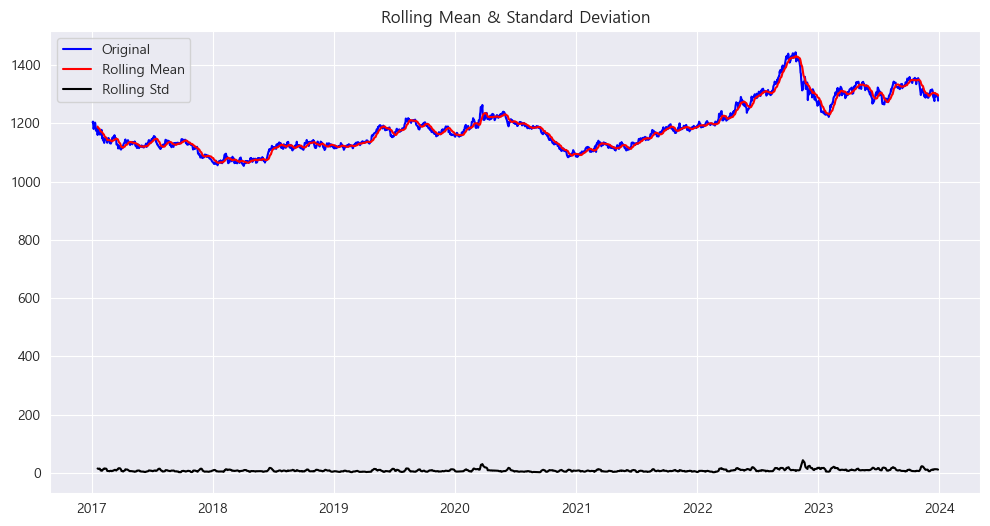

Results of Dickey-Fuller Test:
Test Statistic                   -1.271186
p-value                           0.642250
#Lags Used                        6.000000
Number of Observations Used    1760.000000
Critical Value (1%)              -3.434071
Critical Value (5%)              -2.863184
Critical Value (10%)             -2.567645
dtype: float64


In [58]:
er_adf =  df_tmp.set_index('기준일')['환율']
check_stationarity(er_adf)

In [59]:
## p-value가 0.05보타 큼 => 데이터가 정상 과정이 아닐 가능성이 높음
# 정상화 과정 필요

# 1차 차분 수행
diff_data = df_tmp.diff().dropna()

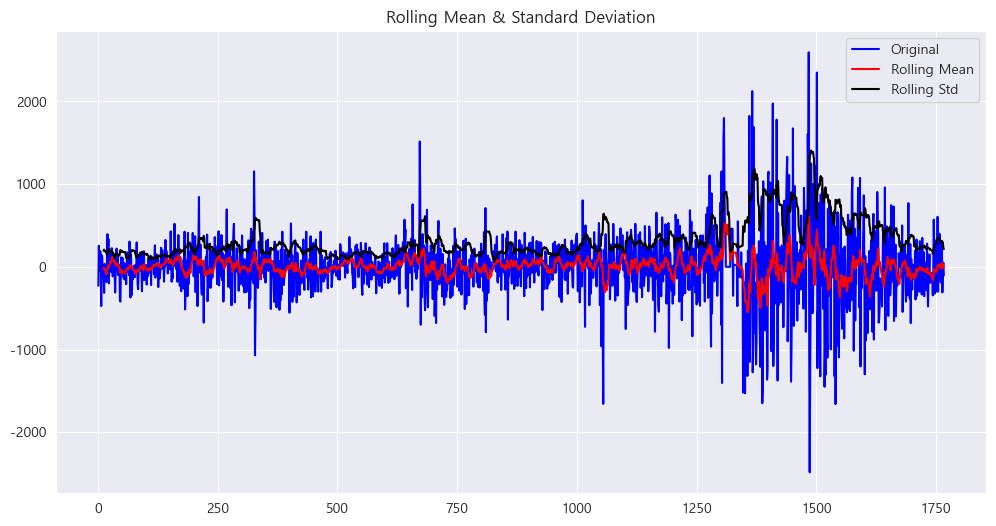

Results of Dickey-Fuller Test:
Test Statistic                -1.836863e+01
p-value                        2.220323e-30
#Lags Used                     4.000000e+00
Number of Observations Used    1.761000e+03
Critical Value (1%)           -3.434069e+00
Critical Value (5%)           -2.863183e+00
Critical Value (10%)          -2.567645e+00
dtype: float64


In [60]:
# 차분 데이터에 대해 Dickey-Fuller 검정 수행
check_stationarity(diff_data['기준가격'])

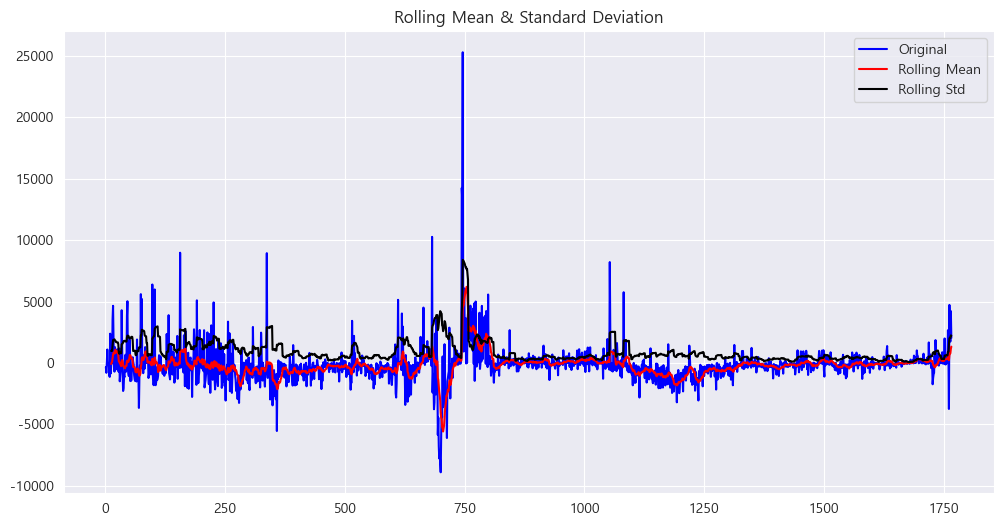

Results of Dickey-Fuller Test:
Test Statistic                   -5.530160
p-value                           0.000002
#Lags Used                       23.000000
Number of Observations Used    1742.000000
Critical Value (1%)              -3.434109
Critical Value (5%)              -2.863201
Critical Value (10%)             -2.567654
dtype: float64


In [61]:
check_stationarity(diff_data['재고량'])

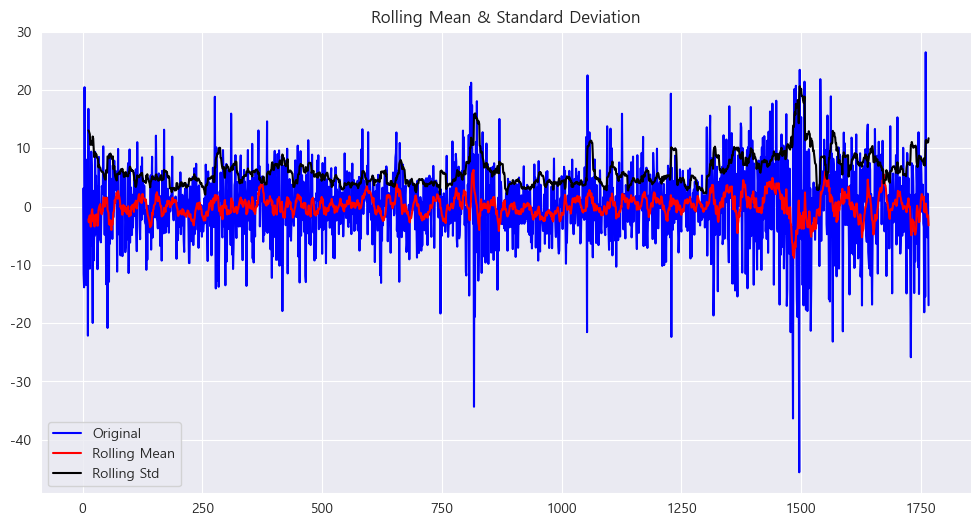

Results of Dickey-Fuller Test:
Test Statistic                -1.813004e+01
p-value                        2.507561e-30
#Lags Used                     5.000000e+00
Number of Observations Used    1.760000e+03
Critical Value (1%)           -3.434071e+00
Critical Value (5%)           -2.863184e+00
Critical Value (10%)          -2.567645e+00
dtype: float64


In [62]:
check_stationarity(diff_data['환율'])

In [63]:
production_consumption

,기준일,생산량,소비량
0,2017-12-31,2065.960,2090.518
1,2018-12-31,2251.992,2339.103
2,2019-12-31,2430.243,2430.139
3,2020-12-31,2528.167,2442.837
4,2021-12-31,2784.683,2962.181
5,2022-12-31,3089.143,3003.505
6,2023-12-31,3429.284,3171.547


재고량과 생산량의 경우 데이터가 연도별로 밖에 없어서 ARIMA 사용 x

In [64]:
df_tmp

,기준일,기준가격,재고량,환율
0,2017-01-03,10205.0,372066,1202.930054
1,2017-01-04,9975.0,371724,1206.010010
2,2017-01-05,10230.0,370920,1194.479980
3,2017-01-06,10185.0,370920,1180.630005
4,2017-01-09,10245.0,372012,1201.099976
...,...,...,...,...
1762,2023-12-21,16670.0,53676,1296.979980
1763,2023-12-22,16360.0,56058,1291.709961
1764,2023-12-27,16355.0,57804,1293.920044
1765,2023-12-28,16405.0,62022,1294.760010


In [65]:
diff_data['날짜'] = df_tmp['기준일'].copy()

In [66]:
diff_data

,기준일,기준가격,재고량,환율,날짜
1,1 days,-230.0,-342.0,3.079956,2017-01-04
2,1 days,255.0,-804.0,-11.530030,2017-01-05
3,1 days,-45.0,0.0,-13.849975,2017-01-06
4,3 days,60.0,1092.0,20.469971,2017-01-09
5,1 days,190.0,-48.0,1.420044,2017-01-10
...,...,...,...,...,...
1762,1 days,315.0,4722.0,-0.780030,2023-12-21
1763,1 days,-310.0,2382.0,-5.270019,2023-12-22
1764,5 days,-5.0,1746.0,2.210083,2023-12-27
1765,1 days,50.0,4218.0,0.839966,2023-12-28


#### ACF, PACF 그래프

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

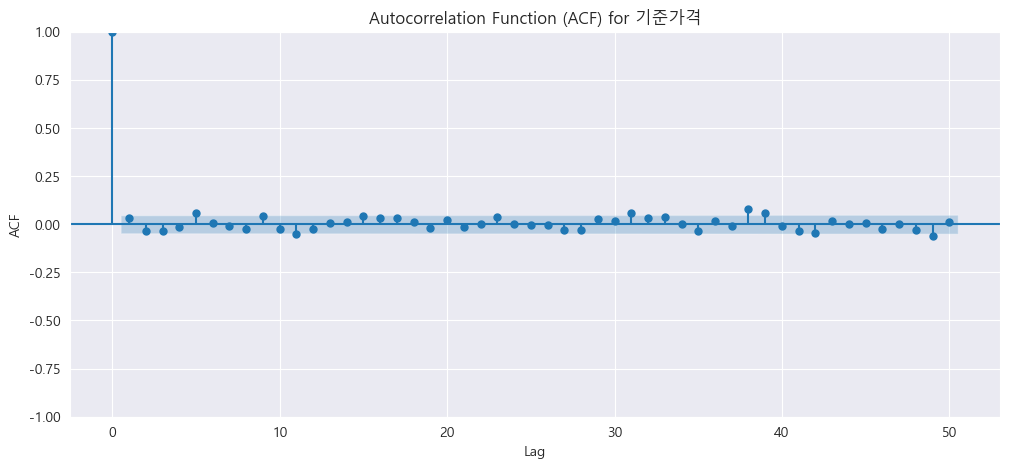

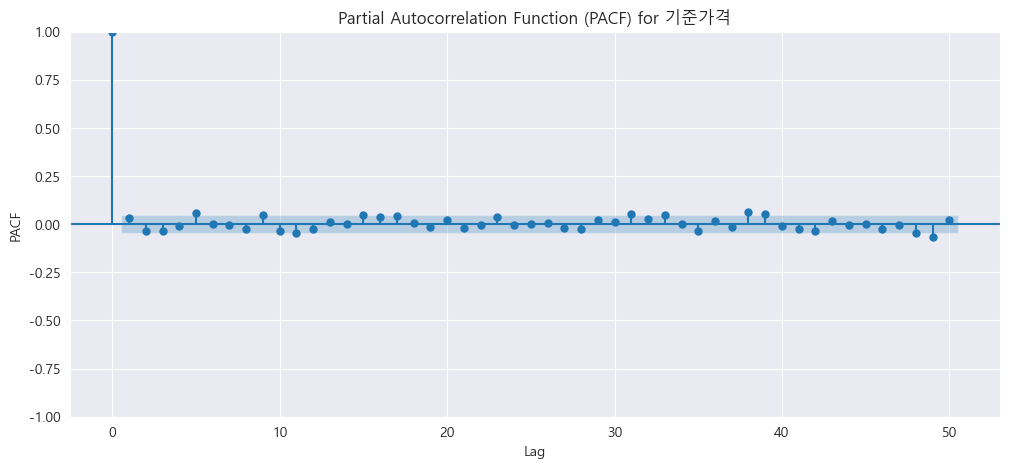

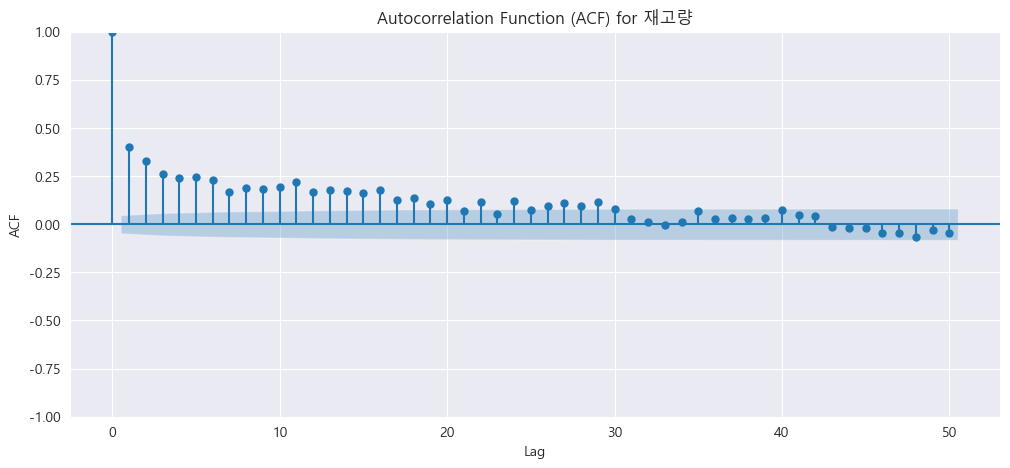

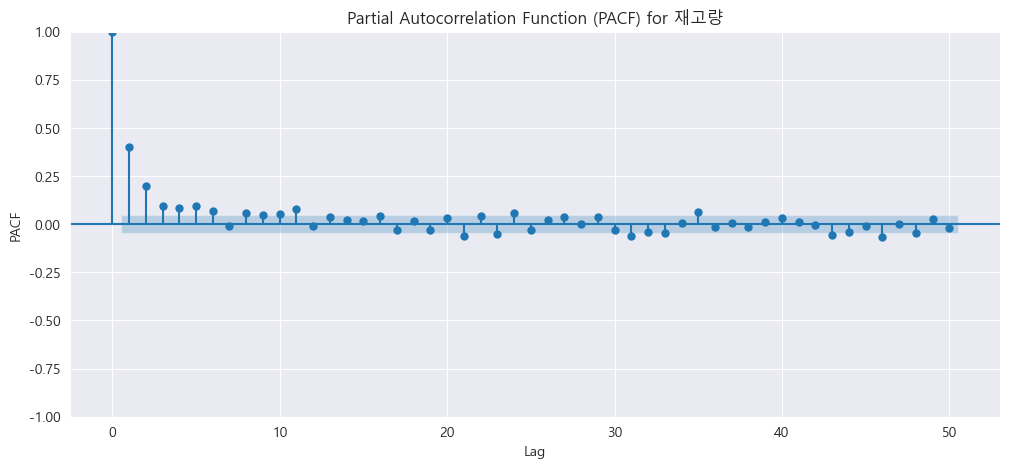

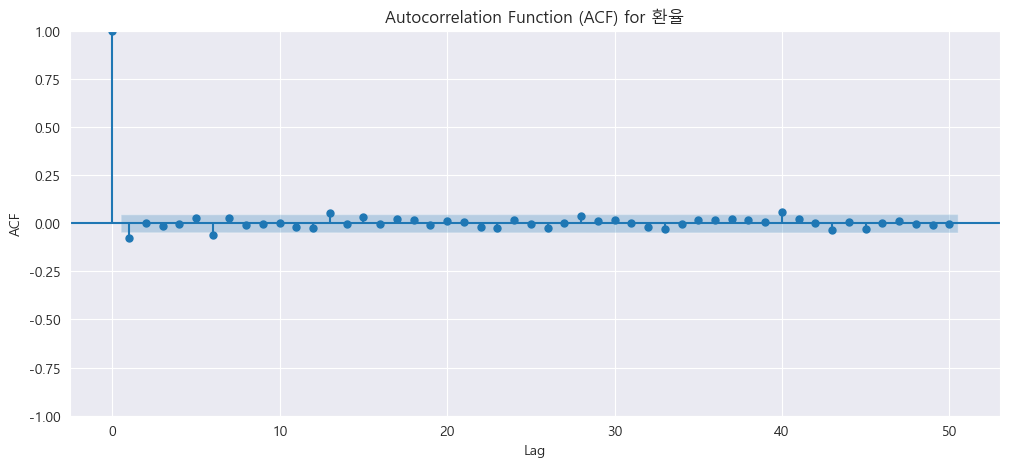

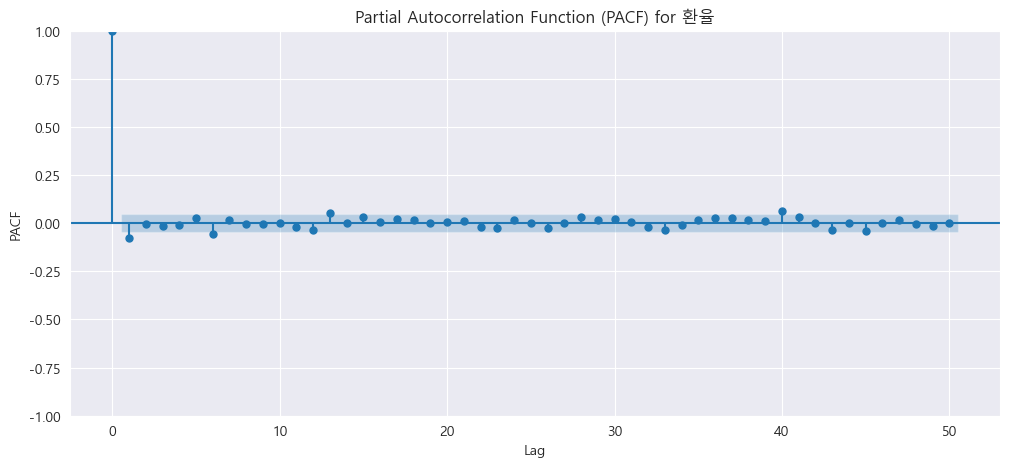

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 날짜를 인덱스로 설정
arima_data = diff_data.set_index('날짜')

# ACF와 PACF 그래프를 그릴 컬럼 리스트
columns = ['기준가격', '재고량', '환율']

# 각 컬럼에 대해 ACF와 PACF 그래프 그리기
for column in columns:
    data = arima_data[column]
    
    # ACF 그래프
    fig, ax = plt.subplots(figsize=(12, 5))
    plot_acf(data, lags=50, ax=ax)  
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.title(f'Autocorrelation Function (ACF) for {column}')
    plt.show()
    
    # PACF 그래프
    fig, ax = plt.subplots(figsize=(12, 5))
    plot_pacf(data, lags=50, ax=ax)  
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.title(f'Partial Autocorrelation Function (PACF) for {column}')
    plt.show()


#### Grid Search : best parameter 찾기

In [69]:
import numpy as np
import itertools
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [70]:
def find_best_arima_params(data, p_range, d_range, q_range):

    best_aic = np.inf
    best_params = None
    
    # Generate all possible combinations of p, d, q
    pdq_combinations = list(itertools.product(p_range, d_range, q_range))
    
    # Iterate through all combinations
    for pdq in pdq_combinations:
        try:
            model = sm.tsa.ARIMA(data, order=pdq)
            results = model.fit()
            current_aic = results.aic
            
            # Save the best parameters
            if current_aic < best_aic:
                best_aic = current_aic
                best_params = pdq
        except:
            continue
    
    print(f"Best ARIMA parameters: {best_params} | AIC: {best_aic}")
    
    return best_params


In [71]:
from statsmodels.tsa.arima.model import ARIMA

def forecast_with_arima(data, column, order, periods):
    model = ARIMA(data[column], order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=periods)
    return forecast

In [72]:
# 가격 최적 파라미터 찾기
arima_data2 = df_tmp.set_index('기준일')
data=arima_data2['기준가격'] 

# 파라미터 범위 설정
p_range = range(0, 3) # AR 차수 범위
d_range = range(0, 2) # 차분 차수 범위
q_range = range(0, 3) # MA 차수 범위

# 최적의 ARIMA 모델 파라미터 찾기
best_params = find_best_arima_params(data, p_range, d_range, q_range)


c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so wil

Best ARIMA parameters: (2, 1, 2) | AIC: 26093.041206354592


In [73]:
# AIC값이 작은 (p,d,q)=(2, 1, 2)로 가격예측
arima_data2 = df_tmp.set_index('기준일')

arima_forecasts2 = pd.DataFrame()
arima_forecasts2['기준가격'] = forecast_with_arima(arima_data2, '기준가격', (2,1,2), 365)

c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


data = arima_data2['기준가격']

# 데이터를 학습 세트와 테스트 세트로 나누기
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# 학습 데이터로 ARIMA 모델 학습
model = ARIMA(train, order=(2,1,2))  # (p, d, q) 값은 데이터에 따라 조정 가능
model_fit = model.fit()

# 테스트 데이터에 대한 예측
forecast = model_fit.forecast(steps=len(test))


c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

In [75]:
# 날짜 컬럼 만들어주기
arima_forecasts2['ds'] = prophet_forecasts_d['ds']

In [76]:
arima_forecasts2

,기준가격,ds
1767,16315.069741,2023-12-30
1768,16291.206326,2023-12-31
1769,16275.256132,2024-01-01
1770,16292.456779,2024-01-02
1771,16308.130890,2024-01-03
...,...,...
2127,16293.385669,2024-12-24
2128,16293.385669,2024-12-25
2129,16293.385669,2024-12-26
2130,16293.385669,2024-12-27


In [77]:
# 재고량 최적 파라미터 찾기
arima_data2 = df_tmp.set_index('기준일')
data=arima_data2['재고량']

# 파라미터 범위 설정
p_range = range(0, 3) # AR 차수 범위
d_range = range(0, 2) # 차분 차수 범위
q_range = range(0, 3) # MA 차수 범위
 
# 최적의 ARIMA 모델 파라미터 찾기
best_params = find_best_arima_params(data, p_range, d_range, q_range)


c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so wil

Best ARIMA parameters: (2, 0, 2) | AIC: 30490.177771824216


In [78]:
# (p,d,q)=(2, 0, 2)로 재고량 예측
arima_forecasts2['재고량'] = forecast_with_arima(arima_data2, '재고량', (2,0,2), 365)

c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

In [79]:
# 환율 최적 파라미터 찾기
arima_data2 = df_tmp.set_index('기준일')
data=arima_data2['환율']

# 파라미터 범위 설정
p_range = range(0, 3) # AR 차수 범위
d_range = range(0, 2) # 차분 차수 범위
q_range = range(0, 3) # MA 차수 범위

# 최적의 ARIMA 모델 파라미터 찾기
best_params = find_best_arima_params(data, p_range, d_range, q_range)


c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so wil

Best ARIMA parameters: (0, 1, 1) | AIC: 11729.46489042318


In [80]:
# (p,d,q)=(0, 1, 1)로 환율예측
arima_forecasts2['환율'] = forecast_with_arima(arima_data2, '환율', (0, 1, 1), 365)

c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

In [81]:
arima_forecasts2 = arima_forecasts2[['ds','기준가격','재고량','환율']]

In [82]:
arima_forecasts2

,ds,기준가격,재고량,환율
1767,2023-12-30,16315.069741,65592.161883,1279.096551
1768,2023-12-31,16291.206326,67046.471425,1279.096551
1769,2024-01-01,16275.256132,68439.862092,1279.096551
1770,2024-01-02,16292.456779,69775.455038,1279.096551
1771,2024-01-03,16308.130890,71056.209525,1279.096551
...,...,...,...,...
2127,2024-12-24,16293.385669,155197.934648,1279.096551
2128,2024-12-25,16293.385669,155305.901982,1279.096551
2129,2024-12-26,16293.385669,155413.566589,1279.096551
2130,2024-12-27,16293.385669,155520.929318,1279.096551


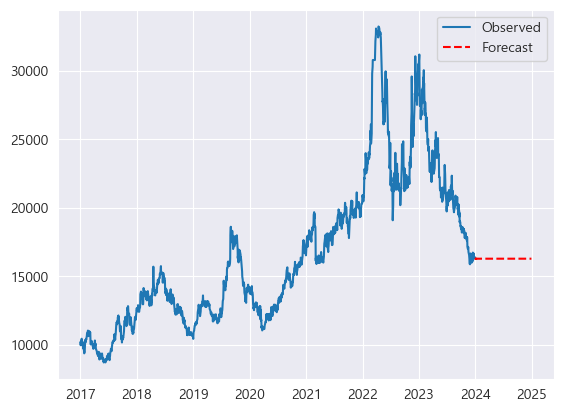

In [83]:
# 예측 결과 시각화
# 날짜(ds)를 인덱스로 설정
forecast_arima = arima_forecasts2.set_index('ds')
df = df_tmp.set_index('기준일')

plt.plot(df.index, df['기준가격'], label='Observed')
plt.plot(forecast_arima.index, forecast_arima['기준가격'], label='Forecast', linestyle='--', color='r')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

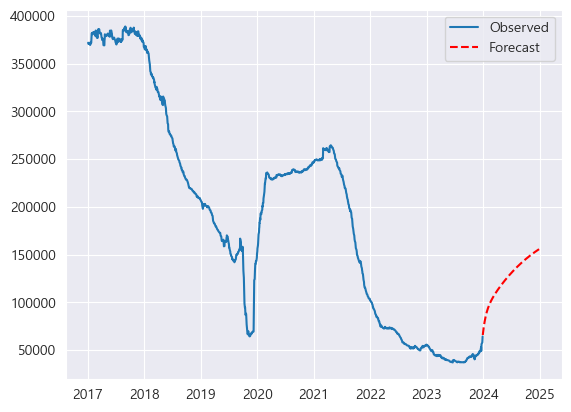

In [84]:
# 예측 결과 시각화
# 날짜(ds)를 인덱스로 설정
forecast_arima = arima_forecasts2.set_index('ds')
df = df_tmp.set_index('기준일')

plt.plot(df.index, df['재고량'], label='Observed')
plt.plot(forecast_arima.index, forecast_arima['재고량'], label='Forecast', linestyle='--', color='r')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

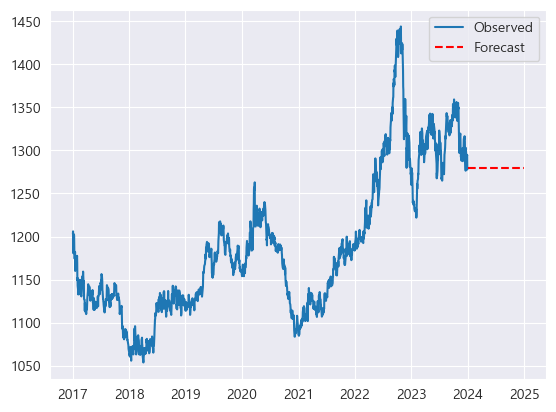

In [85]:
# 예측 결과 시각화
# 날짜(ds)를 인덱스로 설정
forecast_arima = arima_forecasts2.set_index('ds')
df = df_tmp.set_index('기준일')

plt.plot(df.index, df['환율'], label='Observed')
plt.plot(forecast_arima.index, forecast_arima['환율'], label='Forecast', linestyle='--', color='r')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

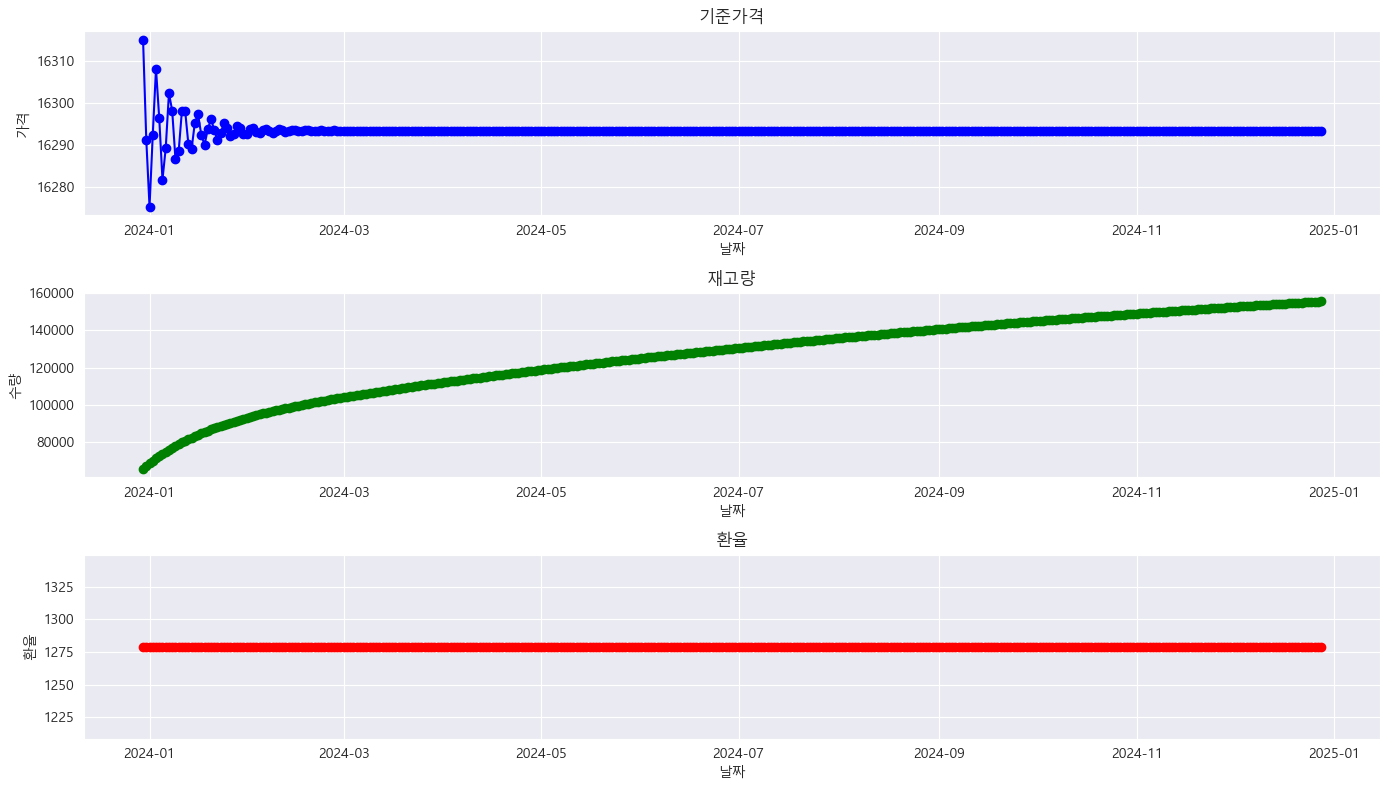

In [86]:
# 날짜(ds)를 인덱스로 설정
forecast_arima = arima_forecasts2.set_index('ds')

# 라인 그래프 그리기
plt.figure(figsize=(14, 8))

# 기준가격 그래프
plt.subplot(3, 1, 1)  # 3행 1열 중 첫 번째
plt.plot(forecast_arima['기준가격'], marker='o', linestyle='-', color='b')
plt.title('기준가격')
plt.xlabel('날짜')
plt.ylabel('가격')

# 재고량 그래프
plt.subplot(3, 1, 2)  # 3행 1열 중 두 번째
plt.plot(forecast_arima['재고량'], marker='o', linestyle='-', color='g')
plt.title('재고량')
plt.xlabel('날짜')
plt.ylabel('수량')

# 환율 그래프
plt.subplot(3, 1, 3)  # 3행 1열 중 세 번째
plt.plot(forecast_arima['환율'], marker='o', linestyle='-', color='r')
plt.title('환율')
plt.xlabel('날짜')
plt.ylabel('환율')

plt.tight_layout()
plt.show()

## prophet과 arima 모델 비교

In [103]:
model_evaluation = pd.DataFrame()

c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

MAE: 2793.0577110874165
MSE: 12938129.878276723
RMSE: 3596.961200552033


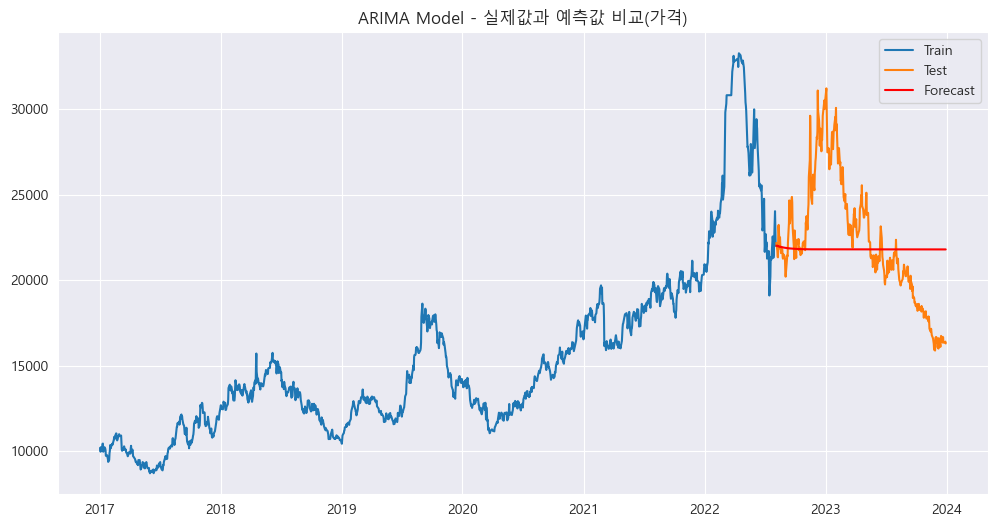

In [104]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 기준가격 시계열 데이터
df = df_tmp.set_index('기준일')
price_series = df['기준가격']

# 훈련 데이터와 테스트 데이터 분할 (80% 훈련, 20% 테스트)
train_size = int(len(price_series) * 0.8)
train, test = price_series[:train_size], price_series[train_size:]

# ARIMA 모델 학습
model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()

# 테스트 데이터 예측
forecast = model_fit.forecast(steps=len(test))

# 성능 평가 지표 계산 => 값이 작을수록 좋음
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
model_evaluation.loc['기준가격', 'ARIMA'] = rmse

# 실제값과 예측값 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model - 실제값과 예측값 비교(가격)')
plt.show()


c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

MAE: 48554.888730496714
MSE: 3079610626.897418
RMSE: 55494.23958301815


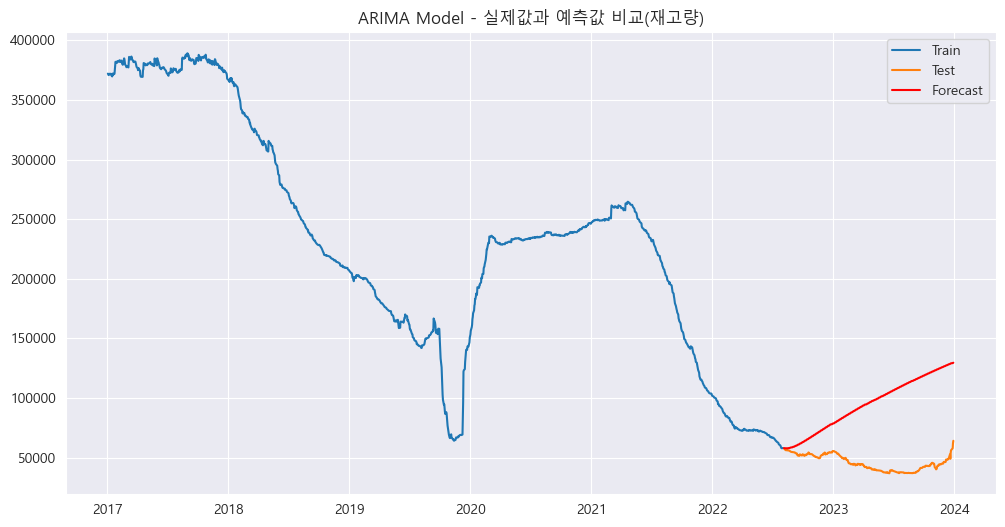

In [105]:

df = df_tmp.set_index('기준일')
stock = df['재고량']

# 훈련 데이터와 테스트 데이터 분할 (80% 훈련, 20% 테스트)
train_size = int(len(stock) * 0.8)
train, test = stock[:train_size], stock[train_size:]

# ARIMA 모델 학습
model = ARIMA(train, order=(2, 0, 2))
model_fit = model.fit()

# 테스트 데이터 예측
forecast = model_fit.forecast(steps=len(test))

# 성능 평가 지표 계산 => 값이 작을수록 좋음
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
model_evaluation.loc['재고량', 'ARIMA'] = rmse

# 실제값과 예측값 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model - 실제값과 예측값 비교(재고량)')
plt.show()


c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

MAE: 34.554254820941615
MSE: 2300.4512412365
RMSE: 47.96301951750432


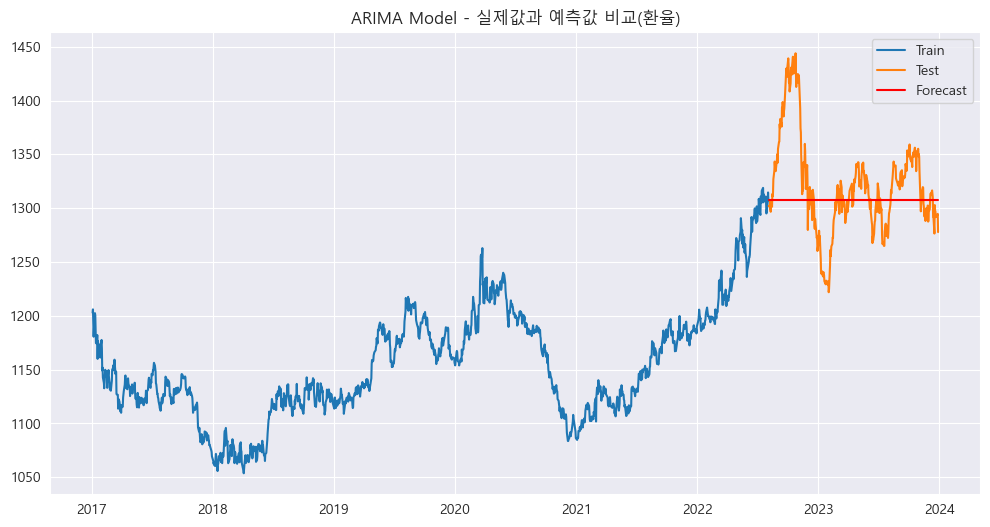

In [106]:

df = df_tmp.set_index('기준일')
exchangerate = df['환율']

# 훈련 데이터와 테스트 데이터 분할 (80% 훈련, 20% 테스트)
train_size = int(len(exchangerate) * 0.8)
train, test = exchangerate[:train_size], exchangerate[train_size:]

# ARIMA 모델 학습
model = ARIMA(train, order=(0, 1, 1))
model_fit = model.fit()

# 테스트 데이터 예측
forecast = model_fit.forecast(steps=len(test))

# 성능 평가 지표 계산 => 값이 작을수록 좋음
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
model_evaluation.loc['환율', 'ARIMA'] = rmse

# 실제값과 예측값 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model - 실제값과 예측값 비교(환율)')
plt.show()


In [107]:
prophet_forecasts_d

,ds,기준가격,재고량,환율
1767,2023-12-30,19766.710989,34760.689296,1274.062553
1768,2023-12-31,19792.730179,34545.462898,1273.128813
1769,2024-01-01,18873.581438,42352.271907,1274.280779
1770,2024-01-02,18945.868807,42025.964637,1273.993306
1771,2024-01-03,18955.992419,41762.828598,1272.635558
...,...,...,...,...
2127,2024-12-24,13348.878120,30066.117189,1257.434703
2128,2024-12-25,13363.867843,29970.838824,1256.032993
2129,2024-12-26,13367.936857,29899.533876,1254.658793
2130,2024-12-27,13414.516547,29751.064269,1254.539940


In [108]:
# prophet 예측 모델 함수

from prophet import Prophet

def forecast_with_prophet(data, column, periods, freq):
    df = data[['기준일', column]].rename(columns={'기준일': 'ds', column: 'y'})
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)
    return forecast[['ds', 'yhat']].tail(periods)

23:49:30 - cmdstanpy - INFO - Chain [1] start processing
23:49:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 6652.3465969612


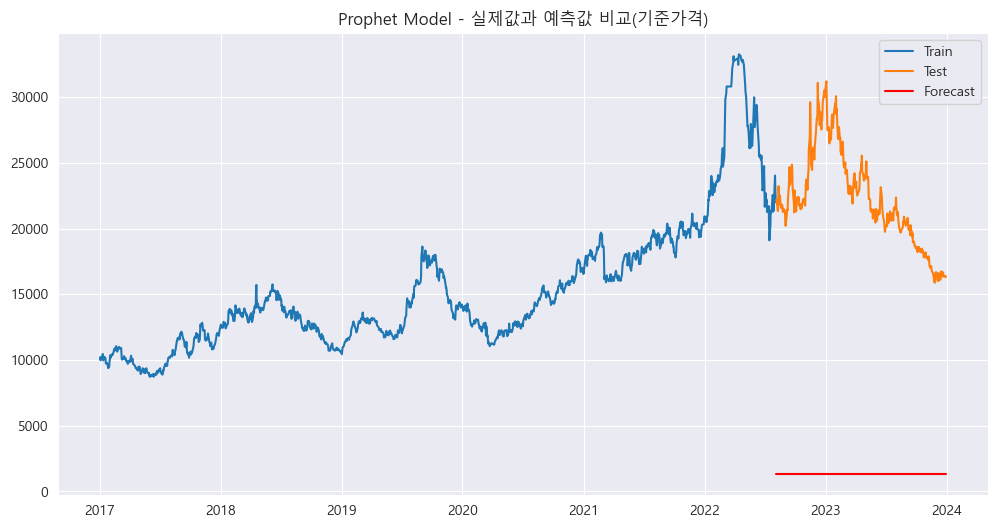

In [109]:
# 데이터프레임을 인덱스로 설정하지 않음
data = df_tmp[['기준일', '기준가격']]

# # 데이터프레임을 인덱스 기준으로 설정
# df = df_tmp.set_index('기준일')
# exchangerate = df_tmp['환율']

# 훈련 데이터와 테스트 데이터 분할 (80% 훈련, 20% 테스트)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Prophet 예측 수행
forecast_prophet = forecast_with_prophet(data, '기준가격', len(test), 'D')

# 성능 평가 지표 계산 => 값이 작을수록 좋음
# test = test.reset_index().rename(columns={'기준일': 'ds'})
# forecast_prophet = forecast_prophet.set_index('ds').reindex(test['ds'])


mse_prophet = mean_squared_error(test['기준가격'], forecast_prophet['yhat'])
rmse_prophet = np.sqrt(mse_prophet)

# print(f'Prophet MSE: {mse_prophet}')
print(f'Prophet RMSE: {rmse_prophet}')

# 모델 평가 결과 저장
model_evaluation.loc['기준가격', 'Prophet'] = rmse_prophet

# 실제값과 예측값 시각화
train = train.set_index('기준일')
test = test.set_index('기준일')
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Prophet Model - 실제값과 예측값 비교(기준가격)')
plt.show()

23:49:32 - cmdstanpy - INFO - Chain [1] start processing
23:49:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 18371.02072930164


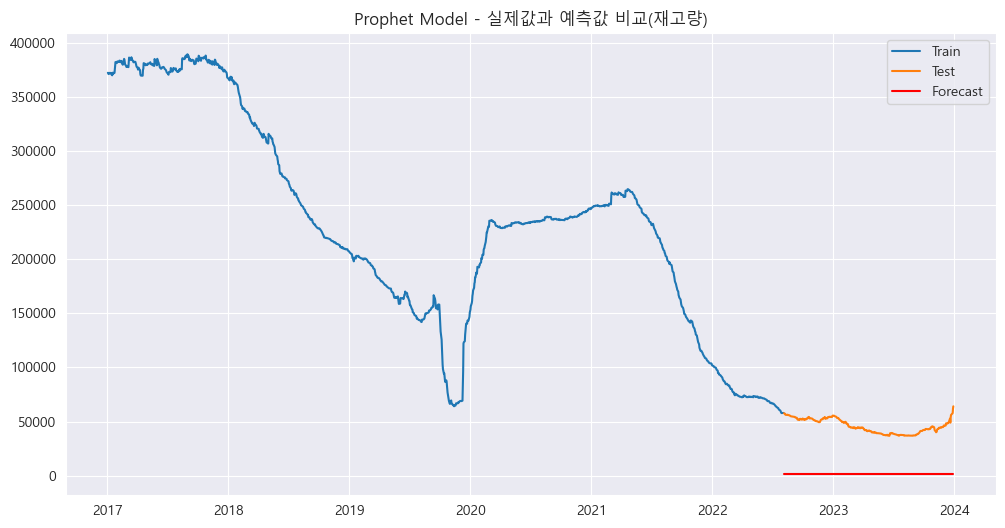

In [110]:
# 데이터프레임을 인덱스로 설정하지 않음
data = df_tmp[['기준일', '재고량']]

# # 데이터프레임을 인덱스 기준으로 설정
# df = df_tmp.set_index('기준일')
# exchangerate = df_tmp['환율']

# 훈련 데이터와 테스트 데이터 분할 (80% 훈련, 20% 테스트)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Prophet 예측 수행
forecast_prophet = forecast_with_prophet(data, '재고량', len(test), 'D')

# 성능 평가 지표 계산 => 값이 작을수록 좋음
# test = test.reset_index().rename(columns={'기준일': 'ds'})
# forecast_prophet = forecast_prophet.set_index('ds').reindex(test['ds'])


mse_prophet = mean_squared_error(test['재고량'], forecast_prophet['yhat'])
rmse_prophet = np.sqrt(mse_prophet)

# print(f'Prophet MSE: {mse_prophet}')
print(f'Prophet RMSE: {rmse_prophet}')

# 모델 평가 결과 저장
model_evaluation.loc['재고량', 'Prophet'] = rmse_prophet

# 실제값과 예측값 시각화
train = train.set_index('기준일')
test = test.set_index('기준일')
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Prophet Model - 실제값과 예측값 비교(재고량)')
plt.show()

23:49:33 - cmdstanpy - INFO - Chain [1] start processing
23:49:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 62.457881331463476


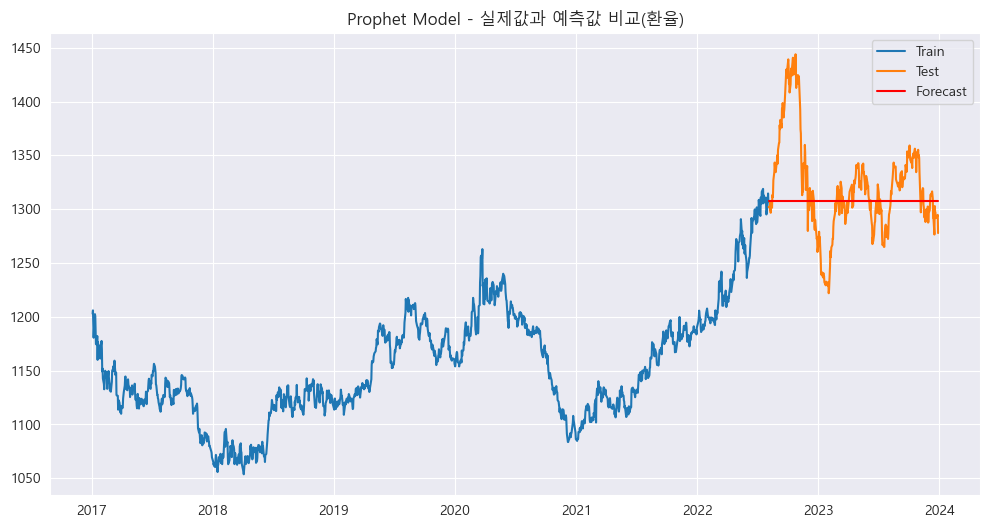

In [111]:
# 데이터프레임을 인덱스로 설정하지 않음
data = df_tmp[['기준일', '환율']]

# # 데이터프레임을 인덱스 기준으로 설정
# df = df_tmp.set_index('기준일')
# exchangerate = df_tmp['환율']

# 훈련 데이터와 테스트 데이터 분할 (80% 훈련, 20% 테스트)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Prophet 예측 수행
forecast_prophet = forecast_with_prophet(data, '환율', len(test), 'D')

# 성능 평가 지표 계산 => 값이 작을수록 좋음
# test = test.reset_index().rename(columns={'기준일': 'ds'})
# forecast_prophet = forecast_prophet.set_index('ds').reindex(test['ds'])


mse_prophet = mean_squared_error(test['환율'], forecast_prophet['yhat'])
rmse_prophet = np.sqrt(mse_prophet)

# print(f'Prophet MSE: {mse_prophet}')
print(f'Prophet RMSE: {rmse_prophet}')

# 모델 평가 결과 저장
model_evaluation.loc['환율', 'Prophet'] = rmse_prophet

# 실제값과 예측값 시각화
train = train.set_index('기준일')
test = test.set_index('기준일')
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Prophet Model - 실제값과 예측값 비교(환율)')
plt.show()

In [112]:
model_evaluation

,ARIMA,Prophet
기준가격,3596.961201,6652.346597
재고량,55494.239583,18371.020729
환율,47.963020,62.457881


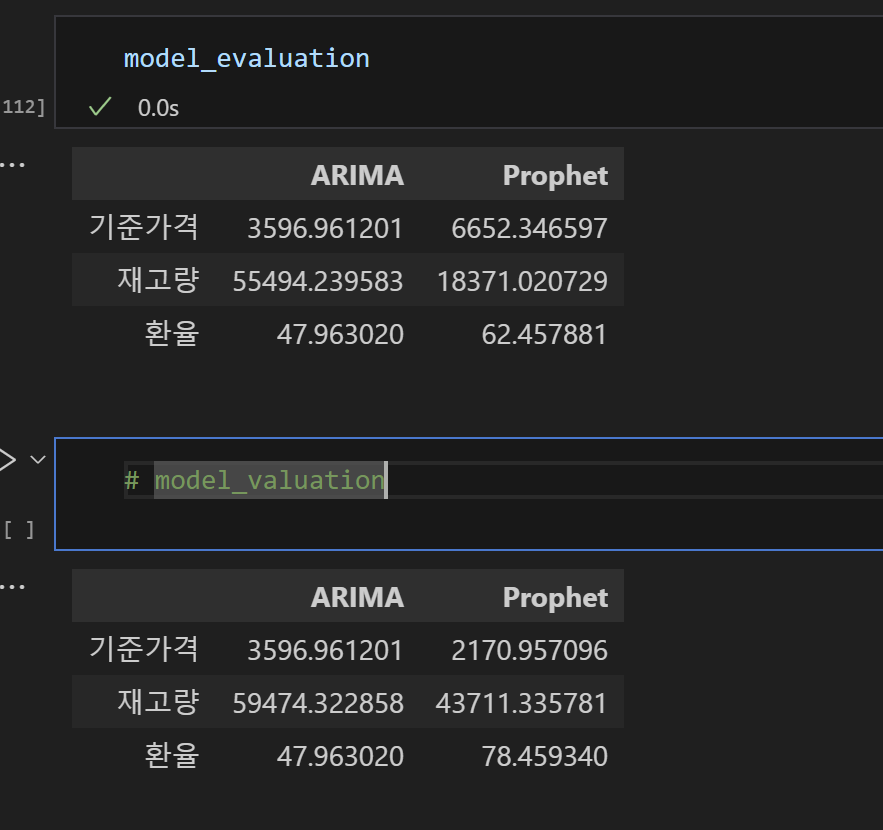

## 분류모델

In [113]:
# 이진분류 : (1 : 공급위기, 0 : 수급안정)
df_nickel['공급위기']=[1. if s<=20 else 0. for s in df_nickel['수급안정화지수']]
df_nickel.head()

,기준일,기준가격,재고량,수급안정화지수,환율,생산량,소비량,공급위기
0,2017-01-01,9984.29,374047,76.63,1169.209961,172.16,174.21,0.0
1,2017-02-01,10619.50,381745,78.24,1133.939941,172.16,174.21,0.0
2,2017-03-01,10230.43,381883,74.56,1117.020020,172.16,174.21,0.0
3,2017-04-01,9668.61,375819,77.10,1135.640015,172.16,174.21,0.0
4,2017-05-01,9154.29,380589,80.06,1123.900024,172.16,174.21,0.0


### RANDOM FOREST

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [135]:
from sklearn.ensemble import RandomForestClassifier

# X: 특성(Feature), y: 타겟 변수(Target)
X = df_nickel.drop(['공급위기','기준일','수급안정화지수'], axis=1)
y = df_nickel['공급위기'] 

# 트레이닝셋과 테스트셋으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Random Forest 모델 생성 및 학습
rf_model = RandomForestClassifier(random_state=13)
rf_model.fit(X_train, y_train)

# 모델 평가
y_pred = rf_model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))




Confusion Matrix:
 [[10  1]
 [ 0  6]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        11
         1.0       0.86      1.00      0.92         6

    accuracy                           0.94        17
   macro avg       0.93      0.95      0.94        17
weighted avg       0.95      0.94      0.94        17



In [136]:
# 하이퍼파라미터 후보
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomForest 분류기 생성
rf_model = RandomForestClassifier()

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters found: ", grid_search.best_params_)

# 최적의 모델로 예측 수행
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# 결과 평가
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best parameters found:  {'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Confusion Matrix:
 [[9 2]
 [0 6]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.82      0.90        11
         1.0       0.75      1.00      0.86         6

    accuracy                           0.88        17
   macro avg       0.88      0.91      0.88        17
weighted avg       0.91      0.88      0.88        17



In [137]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# RandomForestClassifier 모델 초기화
model = RandomForestClassifier(**grid_search.best_params_)

# 교차 검증 전략 정의 (여기서는 StratifiedKFold를 사용)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# 교차 검증 수행
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation 평균 정확도: {:.4f}".format(cv_scores.mean()))
print("각 Fold의 정확도: {}".format(cv_scores))

# 각 Fold에 대한 confusion matrix 및 classification report 출력
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


Cross-validation 평균 정확도: 0.9404
각 Fold의 정확도: [1.         0.88235294 1.         0.88235294 0.9375    ]

Confusion Matrix:
 [[12  0]
 [ 0  5]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17


Confusion Matrix:
 [[12  0]
 [ 2  3]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      1.00      0.92        12
         1.0       1.00      0.60      0.75         5

    accuracy                           0.88        17
   macro avg       0.93      0.80      0.84        17
weighted avg       0.90      0.88      0.87        17


Confusion Matrix:
 [[11  0]
 [ 0  6]]

Classification Report:
               precision    recall  f1-score   suppor

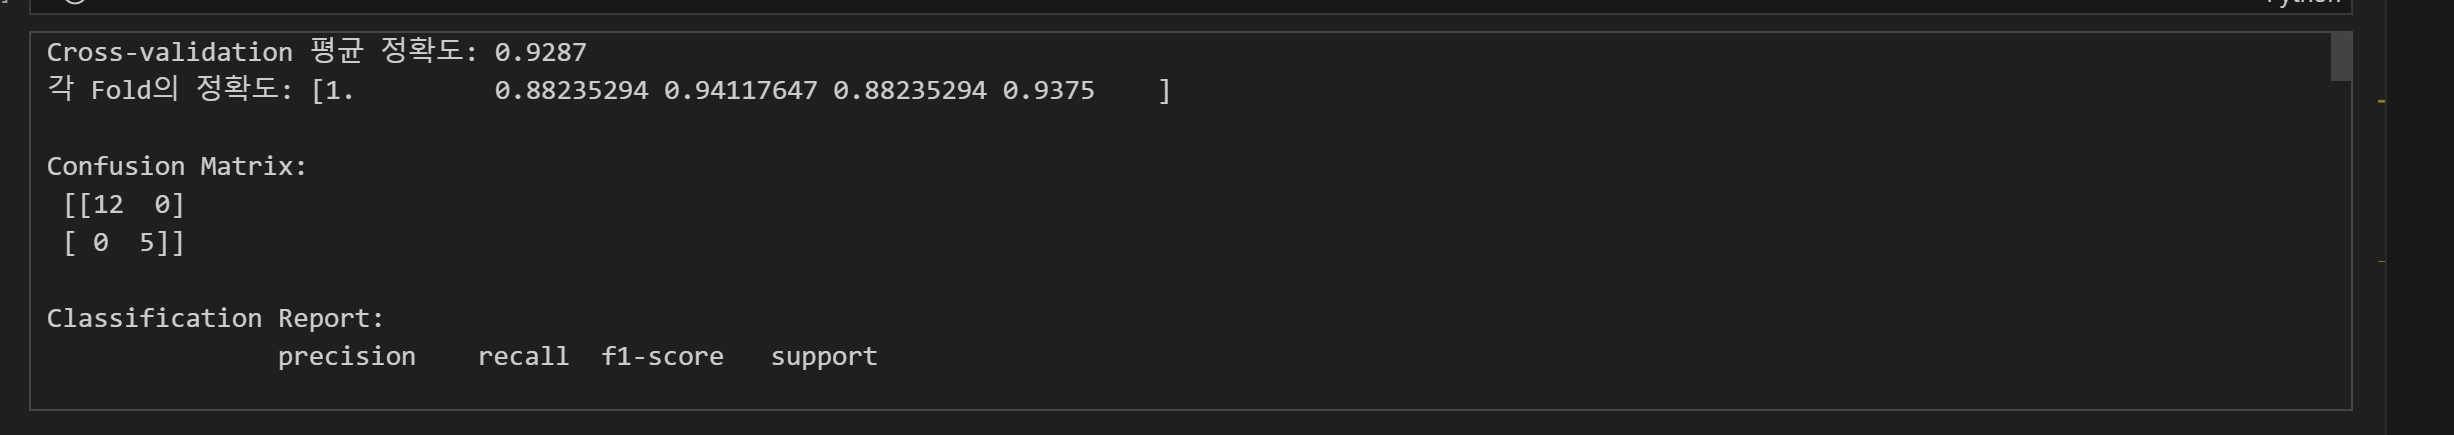

In [138]:
# 예측 결과와 실제 레이블이 다른 샘플들의 인덱스 추출
incorrect_indices = np.where(y_pred != y_test)[0]

# 잘못 분류된 샘플들의 특성 값(X_test) 확인
incorrect_samples = X_test.iloc[incorrect_indices]


In [139]:
incorrect_samples

,기준가격,재고량,환율,생산량,소비량
76,22229.5,39225,1319.790039,285.77,264.3


In [140]:
df_nickel[df_nickel['재고량']==39225]

,기준일,기준가격,재고량,수급안정화지수,환율,생산량,소비량,공급위기
76,2023-05-01,22229.5,39225,18.54,1319.790039,285.77,264.3,1.0


### XGBoost

In [142]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# X: 특성(Feature), y: 타겟 변수(Target)
X = df_nickel.drop(['공급위기','기준일','수급안정화지수'], axis=1)
y = df_nickel['공급위기'] 

# 트레이닝셋과 테스트셋으로 나누기

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# XGBoost 모델 초기화
model = XGBClassifier()

# 모델 훈련
model.fit(X_train, y_train)

# 모델 예측
y_pred = model.predict(X_test)

# 모델 평가
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[11  0]
 [ 0  6]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        11
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17


Accuracy Score: 1.0


In [143]:
# XGBoost 모델 정의
xgb_model = XGBClassifier()

# GridSearchCV를 위한 하이퍼파라미터 후보 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters found: ", grid_search.best_params_)

# 최적의 모델로 예측 수행
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

# 최적의 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the best model: {:.4f}".format(accuracy))


Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Accuracy of the best model: 0.8235


In [144]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# XGBoost 분류기 초기화 및 최적의 하이퍼파라미터 적용
best_xgb_model = XGBClassifier(**grid_search.best_params_)

# 교차 검증 전략 정의 (StratifiedKFold 사용)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# 교차 검증 수행
cv_scores = cross_val_score(best_xgb_model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation 평균 정확도: {:.4f}".format(cv_scores.mean()))
print("각 Fold의 정확도: {}".format(cv_scores))

# 각 Fold에 대한 confusion matrix 및 classification report 출력
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_xgb_model.fit(X_train, y_train)
    y_pred = best_xgb_model.predict(X_test)

    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


Cross-validation 평균 정확도: 0.9287
각 Fold의 정확도: [1.         0.88235294 0.94117647 0.88235294 0.9375    ]

Confusion Matrix:
 [[12  0]
 [ 0  5]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17


Confusion Matrix:
 [[12  0]
 [ 2  3]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      1.00      0.92        12
         1.0       1.00      0.60      0.75         5

    accuracy                           0.88        17
   macro avg       0.93      0.80      0.84        17
weighted avg       0.90      0.88      0.87        17


Confusion Matrix:
 [[10  1]
 [ 0  6]]

Classification Report:
               precision    recall  f1-score   suppor

### LOGISTIC REGRESSION

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# X: 특성(Feature), y: 타겟 변수(Target)
X = df_nickel.drop(['공급위기', '기준일', '수급안정화지수'], axis=1)
y = df_nickel['공급위기'] 

# 트레이닝셋과 테스트셋으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Logistic Regression 모델 초기화
model = LogisticRegression(solver='liblinear')

# 모델 훈련
model.fit(X_train, y_train)

# 모델 예측
y_pred = model.predict(X_test)

# 모델 평가
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[10  1]
 [ 0  6]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        11
         1.0       0.86      1.00      0.92         6

    accuracy                           0.94        17
   macro avg       0.93      0.95      0.94        17
weighted avg       0.95      0.94      0.94        17


Accuracy Score: 0.9411764705882353


In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# 하이퍼파라미터 후보
param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],  # 규제 파라미터 C의 값
    'penalty': ['l1', 'l2'],       # 규제 종류 (L1, L2)
    'solver': ['liblinear']        # 최적화 알고리즘 (liblinear는 작은 데이터셋에 적합)
}

# Logistic Regression 분류기 생성
lr_model = LogisticRegression(max_iter=1000)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters found: ", grid_search.best_params_)

# 최적의 모델로 예측 수행
best_lr_model = grid_search.best_estimator_
y_pred = best_lr_model.predict(X_test)

# 결과 평가
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Best parameters found:  {'C': 100.0, 'penalty': 'l1', 'solver': 'liblinear'}
Confusion Matrix:
 [[11  0]
 [ 0  6]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        11
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [151]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# Logistic Regression 분류기 초기화 및 최적의 하이퍼파라미터 적용
best_lr_model = LogisticRegression(**grid_search.best_params_,max_iter=1000)

# 교차 검증 전략 정의 (StratifiedKFold 사용)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# 교차 검증 수행
cv_scores = cross_val_score(best_lr_model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation 평균 정확도: {:.4f}".format(cv_scores.mean()))
print("각 Fold의 정확도: {}".format(cv_scores))

# 각 Fold에 대한 confusion matrix 및 classification report 출력
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_lr_model.fit(X_train, y_train)
    y_pred = best_lr_model.predict(X_test)

    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


Cross-validation 평균 정확도: 0.9404
각 Fold의 정확도: [1.         0.88235294 0.94117647 0.94117647 0.9375    ]

Confusion Matrix:
 [[12  0]
 [ 0  5]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17


Confusion Matrix:
 [[11  1]
 [ 1  4]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.92      0.92        12
         1.0       0.80      0.80      0.80         5

    accuracy                           0.88        17
   macro avg       0.86      0.86      0.86        17
weighted avg       0.88      0.88      0.88        17


Confusion Matrix:
 [[11  0]
 [ 0  6]]

Classification Report:
               precision    recall  f1-score   suppor

## 모델 성능 비교

평균 정확도 비교

Random Forest: 0.9404

XGBoost: 0.9287

Logistic Regression: 0.9404

Random Forest와 Logistic Regression이 높은 성능을 보이고 있으며, 모델의 해석 가능성을 고려할 때 Logistic Regression을 선택하는 것이 합리적일 수 있음

## 예측데이터로 공급위기 탐지(LOGISTIC REGRESSION사용)

In [174]:
# 월별 평균을 구하기 위해 'ds' 열을 기준으로 월 정보 추출하여 매월 1일로 설정
prophet_forecasts_d['기준일'] = prophet_forecasts_d['ds'].dt.to_period('M').dt.to_timestamp()

# 월별로 그룹화하여 각 월의 평균 계산
monthly_avg = prophet_forecasts_d.groupby('기준일').mean().reset_index()


In [175]:
monthly_avg.drop(columns='ds',inplace=True)

In [177]:
monthly_avg=monthly_avg[monthly_avg['기준일']>='2024-01-01']

In [180]:
monthly_avg

,기준일,기준가격,재고량,환율
1,2024-01-01,19296.850211,38137.867304,1266.476616
2,2024-02-01,19105.040851,34016.524930,1268.763599
3,2024-03-01,18482.031079,33087.555027,1277.336771
4,2024-04-01,18032.363447,31076.174786,1276.130677
5,2024-05-01,16518.254677,31344.292156,1284.106382
6,2024-06-01,15810.775993,26661.670987,1277.606724
7,2024-07-01,14873.909290,25130.035935,1286.000745
8,2024-08-01,15018.156389,25325.145569,1298.845520
9,2024-09-01,14799.441291,27148.266254,1310.586950
10,2024-10-01,13951.146957,22343.869873,1315.096807


In [181]:
prophet_forecasts_y

,ds,생산량,소비량
7,2024-12-31,3648.794281,3249.542706
8,2025-12-31,3917.901521,3568.176923
9,2026-12-31,4222.362699,3789.673982


In [201]:
# 2024년 데이터만 필터링
production_consumption_2024 = prophet_forecasts_y[prophet_forecasts_y['ds'].dt.year == 2024]

# 월별로 나눈 값 계산
production_consumption_2024['생산량'] = production_consumption_2024['생산량'] / 12
production_consumption_2024['소비량'] = production_consumption_2024['소비량'] / 12



# '생산량'과 '소비량' 열 추가
monthly_avg['생산량'] = production_consumption_2024['생산량'].values[0]
monthly_avg['소비량'] = production_consumption_2024['소비량'].values[0]


C:\Users\user\AppData\Local\Temp\ipykernel_30200\1287716795.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  production_consumption_2024['생산량'] = production_consumption_2024['생산량'] / 12
C:\Users\user\AppData\Local\Temp\ipykernel_30200\1287716795.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  production_consumption_2024['소비량'] = production_consumption_2024['소비량'] / 12
C:\Users\user\AppData\Local\Temp\ipykernel_30200\1287716795.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [216]:
data_2024 = monthly_avg[monthly_avg.columns[[0,1,2,3,4,5]]]
data_2024.head()

,기준일,기준가격,재고량,환율,생산량,소비량
1,2024-01-01,19296.850211,38137.867304,1266.476616,304.06619,270.795226
2,2024-02-01,19105.040851,34016.524930,1268.763599,304.06619,270.795226
3,2024-03-01,18482.031079,33087.555027,1277.336771,304.06619,270.795226
4,2024-04-01,18032.363447,31076.174786,1276.130677,304.06619,270.795226
5,2024-05-01,16518.254677,31344.292156,1284.106382,304.06619,270.795226


In [217]:
df_nickel

,기준일,기준가격,재고량,수급안정화지수,환율,생산량,소비량,공급위기
0,2017-01-01,9984.29,374047,76.63,1169.209961,172.16,174.21,0.0
1,2017-02-01,10619.50,381745,78.24,1133.939941,172.16,174.21,0.0
2,2017-03-01,10230.43,381883,74.56,1117.020020,172.16,174.21,0.0
3,2017-04-01,9668.61,375819,77.10,1135.640015,172.16,174.21,0.0
4,2017-05-01,9154.29,380589,80.06,1123.900024,172.16,174.21,0.0
...,...,...,...,...,...,...,...,...
79,2023-08-01,20497.73,37074,28.00,1323.030029,285.77,264.30,0.0
80,2023-09-01,19629.05,39516,30.97,1351.930054,285.77,264.30,0.0
81,2023-10-01,18255.23,43572,31.98,1348.069946,285.77,264.30,0.0
82,2023-11-01,16979.77,43515,41.74,1288.359985,285.77,264.30,0.0


In [218]:

# X: 특성(Feature), y: 타겟 변수(Target)
X = df_nickel.drop(['공급위기', '기준일', '수급안정화지수'], axis=1)
y = df_nickel['공급위기'] 

# 2. 모델 학습 (전체 데이터를 사용)

best_lr_model.fit(X, y)

# 3. 2024년 예측 데이터 로드
X_pred = data_2024.drop(['기준일'], axis=1)

# 4. 2024년 예측 수행
y_2024_pred = model.predict(X_pred)

# 예측 결과를 데이터프레임에 추가
data_2024['공급위기'] = y_2024_pred



In [219]:
data_2024

,기준일,기준가격,재고량,환율,생산량,소비량,공급위기
1,2024-01-01,19296.850211,38137.867304,1266.476616,304.06619,270.795226,0.0
2,2024-02-01,19105.040851,34016.524930,1268.763599,304.06619,270.795226,0.0
3,2024-03-01,18482.031079,33087.555027,1277.336771,304.06619,270.795226,0.0
4,2024-04-01,18032.363447,31076.174786,1276.130677,304.06619,270.795226,0.0
5,2024-05-01,16518.254677,31344.292156,1284.106382,304.06619,270.795226,0.0
6,2024-06-01,15810.775993,26661.670987,1277.606724,304.06619,270.795226,0.0
7,2024-07-01,14873.909290,25130.035935,1286.000745,304.06619,270.795226,0.0
8,2024-08-01,15018.156389,25325.145569,1298.845520,304.06619,270.795226,0.0
9,2024-09-01,14799.441291,27148.266254,1310.586950,304.06619,270.795226,0.0
10,2024-10-01,13951.146957,22343.869873,1315.096807,304.06619,270.795226,0.0


📌 2024년에는 니켈 공급위기가 없을 것으로 예상